# Scasat to deconvolute cell-type

__Prerequisites:__

In order to use Scasat, you have to have the following tools installed in the machine where you are running Scasat
1. [samtools](http://www.htslib.org)
2. [bedtools](http://bedtools.readthedocs.io/en/latest/)
3. [macs2](https://github.com/taoliu/MACS)

If you are using jupyter from anaconda installation then you can install the tools with the following command
* samtools: conda install -c bioconda samtools
* bedtools: conda install -c bioconda bedtools 
* macs2: conda install -c bioconda macs2 (please note that macs2 only runs on python2.7 so you have to create a python2.7 environment if you are using python3

This jupyter notebook introduces __S__ingle-__c__ell __A__TAC-seq __A__nalysis __T__ool (Scasat) to deconvolute three cell types from a complex cell mixture. Scasat analyses single cell ATAC-seq data to identify regulatory regions that separates cells from a complex population. This notebook is the tool mentioned in [___Murtuza Baker et. al.___]()

__Experimental design:__

Two classic oesophageal adenocarcinoma (OAC) cell lines, OE19, OE33 and one non-neoplastic HET1A cell line were mixed together to create the complex mixture of population. These three cell lines were mixed at equal proportion to create this mixture. Single cell ATAC-seq was then performed on those two replicates by loading on two separate C1 fluidigm chips using a $96$ well plate integrated fluidic circuit (IFC) and sequenced on an Illumina NextSeq. This experimental figure is shown in the figure below

<img src="ExperimentalDesign.png" alt="Experimental Desing" style="width: 500px;"/>


__Objective:__

* Establish single cell ATAC-seq pipeline.
* Identify the three different cells from the complex mixture



### Import python packages

We import the python packages.

In [1]:
import subprocess, os, csv, signal, rpy2
import numpy as np
import readline
import rpy2.robjects
import matplotlib.pyplot as plt
import csv
from operator import itemgetter
%matplotlib inline

This code toggles between showing/hiding the codes. The outputs and the discussions would always be visible.

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true;
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
}
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')



rpy2 package provides a simple and robust access to `R` from within `Python`. The following cells loads the package to run `R` code within `Python` notebook. To write and execute `R` code we will use the magic command `%%R` at the top of the cell. 

In [2]:
%load_ext rpy2.ipython

## Python Functions

Below we define the python functions for Scasat. One of the advantage of Scasat is the use of both python and R programming language. We use python for file processing and R for doing the data analysis.

In [3]:
def formatSummitBed(summitFile, fileToSave):
#fileToSave = 'location_toSave/AllFiles_Filtered_summits_shifted.bed' 
#peakFile = 'location_PeakFile/AllFiles_Filtered_summits.bed'

    with open(summitFile,'r') as f:
        peaks=[x.strip().split('\t') for x in f]
    for i in range(len(peaks)):
        peaks[i][1] = str(int(peaks[i][1]) - 250)
        peaks[i][2] = str(int(peaks[i][2]) + 250)

    peaks.sort(key=lambda x: float(x[4]), reverse=True)

    with open(fileToSave, "w") as f:
        writer = csv.writer(f,delimiter='\t')
        writer.writerows(peaks)

`formatSummitBed()`: 
> This functions formats the summit file by adding 500 bp distance from the summit position.

Arguments:
> `summitFile` : The name of the summit file. This has to be the file that is generated from the aggreagated `BAM` file<br>
> `fileToSave`: The name of the file where the save the peak file with the 500 bp peaks.

Value:
> File with 500 bp peaks.

In [4]:
def getMergedBam(BAMFolder, BAMFilePattern):
    
    import pandas as pd
    
        
    mergeFiles = ''
    for root, folder, files in os.walk(BAMFolder):
            files = [os.path.join(root, f) for f in files if (f.endswith(BAMFilePattern))]
            for f in files:
                mergeFiles = mergeFiles +  f + ' '
    
        
    mergeCommand = 'samtools merge ' + BAMFolder + 'AllFiles_Filtered_Merged_nodup.bam' + ' ' + mergeFiles    
    subprocess.call(mergeCommand, shell=True)   
    
    indexMergeCmd = 'samtools index ' + BAMFolder + 'AllFiles_Filtered_Merged_nodup.bam'
    subprocess.call(indexMergeCmd, shell=True)
    
    cleanCommand = 'samtools view -b ' + BAMFolder + 'AllFiles_Filtered_Merged_nodup.bam' + ' ' \
                    + 'chr1 chr2 chr3 chr4 chr5 chr6 chr7 chr8 chr9 chr10 chr11 chr12 chr13 chr14' \
                    + ' chr15 chr16 chr17 chr18 chr19 chr20 chr21 chr22 chrX  > ' \
                    + BAMFolder + 'AllFiles_Filtered_Merged_nodup_cleaned.bam'
    subprocess.call(cleanCommand, shell=True)            
   
    sortMergeCmd = 'samtools sort ' + BAMFolder + 'AllFiles_Filtered_Merged_nodup_cleaned.bam' \
                    + '>' + BAMFolder + 'AllFiles_Filtered_Merged_nodup_cleaned_sorted.bam'        
    subprocess.call(sortMergeCmd, shell=True)
    
    indexMergeCmd = 'samtools index ' + BAMFolder + 'AllFiles_Filtered_Merged_nodup_cleaned_sorted.bam'
    subprocess.call(indexMergeCmd, shell=True) 

`getMergedBam()`:
> merges all the individual `BAM` files for each of the cells and creates `AllFiles_Filtered_Merged_nodup.bam` file. This file is then sorted and indexed.

Arguements:
> `BAMFolder`: Location of the folder where all the BAM files for each of the single-cells are. <br>
> `BAMFilePattern` : The end pattern of the `BAM` files to be merged.

Value:
> The merged `BAM` file `AllFiles_Filtered_Merged_nodup_sorted.bam`. 

In [5]:
def getAggregatedPeak(BAMFolder, BAMFilePattern):
    getMergedBam(BAMFolder, BAMFilePattern)
    
    MergedMacs2Cmd = 'source activate python2; /home/mqbsxsm2/anaconda3/envs/python2/bin/macs2 callpeak -t ' + BAMFolder + 'AllFiles_Filtered_Merged_nodup_cleaned_sorted.bam' +' -n ' \
                    + BAMFolder + 'AllFiles_Filtered' +' -q 0.2 -g hs -f BAMPE --nomodel --nolambda \
                    -B --call-summits --keep-dup all; source deactivate python2'
    subprocess.call(MergedMacs2Cmd, shell=True)
    
    narrowPeakFile = BAMFolder + 'AllFiles_Filtered_peaks.narrowPeak'
    mergedPeakFile = BAMFolder + 'mergedPeaks.bed'
    tmpPeakFile = BAMFolder + 'tmpPeak.txt'
    
    
    with open(narrowPeakFile,'r') as f:
        peaks=[x.strip().split('\t') for x in f]
    peaks.sort(key=lambda x: float(x[8]), reverse=True)
    
    
    peaksToWrite = list()
    for i in range(len(peaks)):
        peaksToWrite.insert(i, peaks[i][0:4])
        peaksToWrite[i].append(peaks[i][8])      
    
    
    with open(mergedPeakFile, "w") as f:
        writer = csv.writer(f,delimiter='\t')        
        writer.writerows(peaksToWrite)        
        
    sortCmd = 'sort -k1,1 -k2,2n ' + mergedPeakFile + ' > ' + tmpPeakFile  
    subprocess.call(sortCmd, shell=True)
    
    bedToolsCmd ='bedtools merge -i ' + tmpPeakFile + ' -c 5 -o last > ' + mergedPeakFile
    subprocess.call(bedToolsCmd, shell=True)
    
    sortCmd = 'sort -nrk4 ' + mergedPeakFile + ' > ' + tmpPeakFile  
    subprocess.call(sortCmd, shell=True)    
    
    copyCmd = 'cat ' + tmpPeakFile + ' > ' + mergedPeakFile
    subprocess.call(copyCmd, shell=True)    

`getAggregatedPeak()`:
> This function calls `MACS2` on the aggregated `BAM` file and generates the peaks. If the user is following the merging BAM option then this is the function they need to call. Then the `getMergedBam()` is called within this function

Arguements:
> `BAMFolder`: Location of the folder where all the BAM files for each of the single-cells are. <br>
> `BAMFilePattern` : The end pattern of the `BAM` files to be merged.

Value:
> Peak files from MACS2 call.

In [6]:
def getAggregatedPeakSE(BAMFolder, BAMFilePattern):
    getMergedBam(BAMFolder, BAMFilePattern)
    
    MergedMacs2Cmd = 'source activate python2; /home/mqbsxsm2/anaconda3/envs/python2/bin/macs2 callpeak -t ' + BAMFolder + 'AllFiles_Filtered_Merged_nodup_cleaned_sorted.bam' +' -n ' \
                    + BAMFolder + 'AllFiles_Filtered' +' -q 0.2 -g hs -f BAM --nomodel --nolambda \
                    -B --call-summits --keep-dup all; source deactivate python2'
    subprocess.call(MergedMacs2Cmd, shell=True)
    
    narrowPeakFile = BAMFolder + 'AllFiles_Filtered_peaks.narrowPeak'
    mergedPeakFile = BAMFolder + 'mergedPeaks.bed'
    tmpPeakFile = BAMFolder + 'tmpPeak.txt'
    
    
    with open(narrowPeakFile,'r') as f:
        peaks=[x.strip().split('\t') for x in f]
    peaks.sort(key=lambda x: float(x[8]), reverse=True)
    
    
    peaksToWrite = list()
    for i in range(len(peaks)):
        peaksToWrite.insert(i, peaks[i][0:4])
        peaksToWrite[i].append(peaks[i][8])      
    
    
    with open(mergedPeakFile, "w") as f:
        writer = csv.writer(f,delimiter='\t')        
        writer.writerows(peaksToWrite)        
        
    sortCmd = 'sort -k1,1 -k2,2n ' + mergedPeakFile + ' > ' + tmpPeakFile  
    subprocess.call(sortCmd, shell=True)
    
    bedToolsCmd ='bedtools merge -i ' + tmpPeakFile + ' -c 5 -o last > ' + mergedPeakFile
    subprocess.call(bedToolsCmd, shell=True)
    
    sortCmd = 'sort -nrk4 ' + mergedPeakFile + ' > ' + tmpPeakFile  
    subprocess.call(sortCmd, shell=True)    
    
    copyCmd = 'cat ' + tmpPeakFile + ' > ' + mergedPeakFile
    subprocess.call(copyCmd, shell=True)  

`getAggregatedPeak()`:
> This function calls `MACS2` on the aggregated `BAM` file mapped as single end reads and generates the peaks. If the user is following the merging BAM option then this is the function they need to call. Then the `getMergedBam()` is called within this function

Arguements:
> `BAMFolder`: Location of the folder where all the BAM files for each of the single-cells are. <br>
> `BAMFilePattern` : The end pattern of the `BAM` files to be merged.

Value:
> Peak files from MACS2 call.

------------------
## R functions

### Loading R packages (if not available it will install it before loading)

In [7]:
%%R
if (!require("pacman")) install.packages("pacman")
pacman::p_load(ggplot2, ComplexHeatmap, Rtsne, prabclus, GGally, rtracklayer, corrplot, 
               cluster, EnsDb.Hsapiens.v86, ChIPpeakAnno, org.Hs.eg.db, rGREAT)

/home/mqbsxsm2/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Loading required package: pacman

  warnings.warn(x, RRuntimeWarning)


### R functions for the Scasat

Now I define all the R functions. These functions will be used for most of the downstream analysis. A short explanation of each function along with its input and output are also given below of each function. 

In [8]:
%%R
peakAccessibility <- function(mergedPeakFile, peakFolder, peakFilePattern, outputFolder, outputPeakFileName){
    if(length(list.files(path=peakFolder, pattern = paste0(peakFilePattern,'.bed'), full.names=TRUE))>0){
        files = list.files(path=peakFolder, pattern = paste0(peakFilePattern,'.bed'), full.names=TRUE)
        unlink(files)
    }
    formatingToBed(peakFolder, peakFilePattern, outputFolder)
    peakFilePattern = paste0(peakFilePattern,'.bed')
    query = import(mergedPeakFile)
    queryDF <- data.frame(query)
    #queryDF <- queryDF[order(queryDF$name, decreasing=TRUE),]    
    
    totalOverlap <- data.frame(seqnames = queryDF$seqnames, start = queryDF$start, end = queryDF$end)    
    files <- list.files(path=peakFolder, pattern = peakFilePattern, full.names=TRUE)
    cellName <- list.files(path=peakFolder, pattern = peakFilePattern)
    for (i in 1:length(files)){
        subject = import(files[i])
        hits = findOverlaps(query, subject)
        hitsDF <- data.frame(hits)
        cellName[i] <- gsub(peakFilePattern, '', cellName[i])
        totalOverlap[hitsDF$queryHits, cellName[i]] <- 1
        totalOverlap[-hitsDF$queryHits, cellName[i]] <- 0
    }
    outputFile = paste0(outputFolder,outputPeakFileName)
    write.table(totalOverlap, outputFile, row.names=FALSE)    
}    


`peakAccesibility()`:
> This function calculates the accessible peaks for each of the cells. It looks at each of the peaks listed in _Aggregated-Peak_ table and tries to find out whether there is any overlap between these peaks and the peaks of each cell. If there is then it puts a 1 agains that cells for that peak. Otherwise it puts 0. Calling these function for each of the cell completes the _Aggregated-Peak_ for which rows represnt all the peaks and the column represents cells.

Arguements:
> `mergedPeakFile`: This is the name and location of `mergedPeaks.bed`.<br>
> `peakFolder`: This is the location of the folder where all the peaks for each of the single-cells are located. <br>
> `peakFilePattern` : The end pattern of the `peak` files of each single cells found in the `peakFolder`. Currently the only two accepted patterns are `_peaks.narrowPeak` and `_summits_shifted.bed` <br>
> `outputFolder`: Folder where all the outputs will be saved
> `outputPeakFileName`: Name of the file where the peak accessibility table, _Aggregated-Peak_ would be saved. This file will contain all the accessibility information for all the cells.


Value:
> Peak accessibile table saved according to the name set in `outputPeakFileName`. The table will have the results in 1 or 0 expression peak opening or closing respectively.

In [9]:
%%R
formatingToBed <- function(peakFolder, peakFilePattern, outputFolder){
    files <- list.files(path=peakFolder, pattern = peakFilePattern, full.names=TRUE)
    for (i in 1:length(files)){
        narrowPeak <- read.csv(files[i], header=FALSE, sep='\t')
        write.table(narrowPeak[,1:4], paste0(files[i],'.bed'), 
                    row.names=FALSE, sep='\t', col.names=FALSE, quote=FALSE)
    }
}

`formatingToBed()`:
> This function formats the bed file suitable for processing by Scasat. It adds a `.bed` extension at the end.

Arguements:
> `mergedPeakFile`: This is the name and location of `mergedPeaks.bed`.<br>
> `peakFolder`: This is the location of the folder where all the peaks for each of the single-cells are located. <br>
> `peakFilePattern` : The end pattern of the `peak` files of each single cells found in the `peakFolder`. Currently the only two accepted patterns are `_peaks.narrowPeak` and `_summits_shifted.bed` <br>
> `outputFolder`: Folder where all the outputs will be saved

Value:
> Formats the bed files with adding a `.bed` extesion.

In [10]:
%%R
calcEntropy <- function(data){
	freqs <- table(data)/sum(table(data))
	return(-sum(freqs * log(freqs)))
}

`calcEntropy()`:
> Calcuates entropy is calculated as
$$\sum_{i=1}^c -p_i log_2 p_i$$


`Usage`:
> `calcEntropy(count_data)`

Arguements:
> `count_data`: The peak information converted into binary. 

Value:
> Returns entropy of the count data.

In [11]:
%%R
getDiffAccessInformationGain <- function(cdBinary, groups=NULL){

    if (length(levels(groups)) != 2) {
        stop(paste("ERROR: wrong number of levels in the grouping factor (", 
            paste(levels(groups), collapse = " "), "), but must be two.", 
            sep = ""))
    }
    if (is.null(groups)){
        stop("ERROR: groups factor is not provided")
    }
    
    
    SingleCell.Group1.CellNames <- names(groups[groups==levels(groups)[1]])
    SingleCell.Group2.CellNames <- names(groups[groups==levels(groups)[2]])
    
    SingleCell.Group1.Binary <- cdBinary[,SingleCell.Group1.CellNames]
    SingleCell.Group2.Binary <- cdBinary[,SingleCell.Group2.CellNames]
    
    CellType <- data.frame(CellType=gsub('_.*','',names(groups)))
    
         
    SingleCell.Group1VsGroup2 <- cbind(SingleCell.Group1.Binary,SingleCell.Group2.Binary)
    SingleCell.Group1VsGroup2 <- t(SingleCell.Group1VsGroup2)
    #SingleCell.Group1VsGroup2 <- cbind(SingleCell.Group1VsGroup2,CellType)   

    
    dataDim = (dim(SingleCell.Group1VsGroup2)[2])
    #dataDim = 5
    
    information.gain = vector(mode="numeric", length=(ncol(SingleCell.Group1VsGroup2)-1))
    SingleCell.Group1VsGroup2.res <- data.frame(Chr = cdBinary[1:dataDim,1],
                                           Start = cdBinary[1:dataDim,2],
                                           end = cdBinary[1:dataDim,3])        
    
    
    for(i in 1:dataDim)
    {
        jointData = cbind(SingleCell.Group1VsGroup2[,i], CellType)
        
        gain <- calcEntropy(jointData[,2]) - 
                (sum(table(jointData)[c(1,3)])/length(jointData[,2]))*calcEntropy(jointData[jointData[,1]==0,]) - 
                (sum(table(jointData)[c(2,4)])/length(jointData[,2]))*calcEntropy(jointData[jointData[,1]==1,])
        SingleCell.Group1VsGroup2.res$information.gain[i] <- gain        
    }
    
        
    SingleCell.Group1.rawAvg <- rowSums(SingleCell.Group1.Binary==1)/dim(SingleCell.Group1.Binary)[2]
    SingleCell.Group2.rawAvg <- rowSums(SingleCell.Group2.Binary==1)/dim(SingleCell.Group2.Binary)[2]
    
    SingleCell.Group1VsGroup2.res$rawMeanGroup1 <- SingleCell.Group1.rawAvg
    SingleCell.Group1VsGroup2.res$rawMeanGroup2 <- SingleCell.Group2.rawAvg
    SingleCell.Group1VsGroup2.res$log2FoldChange <- log2(SingleCell.Group1VsGroup2.res$rawMeanGroup1/
                                                       SingleCell.Group1VsGroup2.res$rawMeanGroup2)
    

    #write.csv(SingleCell.Group1VsGroup2[order(SingleCell.Group1VsGroup2$information.gain, decreasing=TRUE),], 
    #          paste0(levels(groups)[1],'_vs_',levels(groups)[2],'InformationGain.csv'), row.names=FALSE)
    
    SingleCell.Group1VsGroup2.res <- SingleCell.Group1VsGroup2.res[!is.nan(SingleCell.Group1VsGroup2.res$information.gain) &
                                                                  !is.na(SingleCell.Group1VsGroup2.res$information.gain),]
    
    return(SingleCell.Group1VsGroup2.res)    
}

`getDiffAccessInformationGain()`:
> Caculates differential accessibility between two groups of cells using entropy and information gain. For each peak the accessibility is encoded as a binary variable. For each peak we calculate the "Information gain" by having the peak divided into two groups of cells for which we are trying to find out the differential accessibilty. The Information gain is calculated as

$$ 
 Gain(P, P_{G_1}, P_{G_2}) = Entropy(P) - \sum_{v \epsilon\{G_1,G_2 \}} \frac{|P_v|}{|P|}Entropy(P_v)
$$

>where Entropy is calculated as
$$\sum_{i=1}^c -p_i log_2 p_i$$

> The peaks are then sorted based on the informatin gain and the user can choose the cutoff value for selecting the DA peaks. A suggested value for this would be values < 0.01


`Usage`:
> `getDiffAccessLogsitic(count_data, groups)`

Arguements:
> `cdBinary`: The peak information converted into binary. Ideally this would be file that set in the `outputPeakFileName`. `cdBinary` would be used to calculate the Jaccard distance which would then be used as d matrix in MDS calculation<br>

>`groups` : groups into which each cell belong to.

Value:
> Returns a table with the peaks along with Information gain.

In [12]:
%%R
getDiffAccess <- function(cdBinary, groups=NULL){

    if (length(levels(groups)) != 2) {
        stop(paste("ERROR: wrong number of levels in the grouping factor (", 
            paste(levels(groups), collapse = " "), "), but must be two.", 
            sep = ""))
    }
    if (is.null(groups)){
        stop("ERROR: groups factor is not provided")
    }
    
    
    SingleCell.Group1.CellNames <- names(groups[groups==levels(groups)[1]])
    SingleCell.Group2.CellNames <- names(groups[groups==levels(groups)[2]])
    
    SingleCell.Group1.Binary <- cdBinary[,SingleCell.Group1.CellNames]
    SingleCell.Group2.Binary <- cdBinary[,SingleCell.Group2.CellNames]

    SingleCell.Group1.ZeroCount <- rowSums(SingleCell.Group1.Binary==0)
    SingleCell.Group2.ZeroCount <- rowSums(SingleCell.Group2.Binary==0)
    SingleCell.Group1.OneCount <- rowSums(SingleCell.Group1.Binary==1)
    SingleCell.Group2.OneCount <- rowSums(SingleCell.Group2.Binary==1)
    
    SingleCell.Group1VsGroup2 <- data.frame(Chr = cdBinary[,1],
                                           Start = cdBinary[,2],
                                           end = cdBinary[,3])

    SingleCell.Group1VsGroup2$group1OneCounts <- SingleCell.Group1.OneCount
    SingleCell.Group1VsGroup2$group2OneCounts <- SingleCell.Group2.OneCount
    SingleCell.Group1VsGroup2$log2Fold <- log2((SingleCell.Group1.OneCount+1)/dim(SingleCell.Group1.Binary)[2]) - 
                                            log2(((SingleCell.Group2.OneCount+1)/dim(SingleCell.Group2.Binary)[2]))
    pvalue = vector(mode="numeric", length=length(SingleCell.Group2.OneCount))
    nGenes <- nrow(SingleCell.Group1.Binary)
    
    
    for(i in 1:length(SingleCell.Group2.OneCount))
    {
        contingencyTable <- matrix(c(SingleCell.Group1.ZeroCount[i], SingleCell.Group2.ZeroCount[i],
                                     SingleCell.Group1.OneCount[i], SingleCell.Group2.OneCount[i]), ncol=2)
        SingleCell.Group1VsGroup2$pvalue[i] <- fisher.test(contingencyTable)$p.value        
    }
    
    # Bonferroni correction
    SingleCell.Group1VsGroup2$p_adjust <- p.adjust(SingleCell.Group1VsGroup2$pvalue, method="bonferroni")

    write.csv(SingleCell.Group1VsGroup2[order(SingleCell.Group1VsGroup2$p_adjust, decreasing=FALSE),], 
              paste0(levels(groups)[1],'_vs_',levels(groups)[2],'.csv'), row.names=FALSE)
    
    return(SingleCell.Group1VsGroup2)    
}

`getDiffAccess()`:
> Caculates differential accessibility between two groups of cells. For each peak it creates a contingency table with number of 0's and 1's for the two groups. <br>

>|               	| Group-1 	| Group-2 	|
|---------------	|---------	|---------	|
| Number of 0's 	|         	|         	|
| Number of 1's 	|         	|         	| 
<br>
It then runs Fisher exact test to calculate the p-values. These p-values are then corrected for multiple testing with Bonferroni correction. Finally the function returns a table with the peaks, their count of 1's in each group, the p-value and the q-value (corrected p-value).

Arguements:
> `cdBinary`: The peak information converted into binary. Ideally this would be file that set in the `outputPeakFileName`. `cdBinary` would be used to calculate the Jaccard distance which would then be used as d matrix in MDS calculation<br>

Value:
> Returns a table with the peaks, their count of 1's in each group, the p-value and the q-value (corrected p-value).

In [13]:
%%R
getPeakVsPrecision <- function(peakA, peakB,start=100,stepSize=100){
    
    if (colnames(peakA)[1] != 'chr' | colnames(peakA)[2] != 'start' | colnames(peakA)[3] != 'end') {
        stop(paste("ERROR: Column name should have 'chr' 'start' 'end'"))
    }

    dimToRun <- min(dim(peakA)[1],dim(peakB)[1])
    if(dim(peakB)[1]>dimToRun){
        peakB <- peakB[1:dimToRun,]
    }
    GenomicRangeObjA <- makeGRangesFromDataFrame(peakA,
                         keep.extra.columns=FALSE,
                         ignore.strand=TRUE,
                         seqinfo=NULL,
                         seqnames.field=c("chr"),
                         start.field="start",
                         end.field=c("end"),
                         starts.in.df.are.0based=FALSE)
    j=1
    Recall <- vector(mode="numeric", length=0)
    Precision <- vector(mode="numeric", length=0)
    for(i in seq(100,(dimToRun-stepSize),stepSize)){
           GenomicRangeObjB <- makeGRangesFromDataFrame(peakB[1:i,],
                         keep.extra.columns=FALSE,
                         ignore.strand=TRUE,
                         seqinfo=NULL,
                         seqnames.field=c("chr"),
                         start.field="start",
                         end.field=c("end"),
                         starts.in.df.are.0based=FALSE)

           write.table(GenomicRangeObjA, 'tmpPeakA.bed', sep='\t', row.names=FALSE, quote=FALSE, col.names=FALSE)
	   write.table(GenomicRangeObjB, 'tmpPeakB.bed', sep='\t', row.names=FALSE, quote=FALSE, col.names=FALSE)
           bedToolsCmd = 'bedtools intersect -a tmpPeakB.bed -b tmpPeakA.bed -u'
           intersectRes = system(bedToolsCmd, intern=TRUE)
           
           FP = dim(peakB[1:i,])[1] - length(intersectRes)
           TP = length(intersectRes)
           
           GenomicRangeObjB <- makeGRangesFromDataFrame(peakB[(i+1):dim(peakB)[1],],
                         keep.extra.columns=FALSE,
                         ignore.strand=TRUE,
                         seqinfo=NULL,
                         seqnames.field=c("Chr"),
                         start.field="Start",
                         end.field=c("End"),
                         starts.in.df.are.0based=FALSE)
                         
           write.table(GenomicRangeObjA, 'tmpPeakA.bed', sep='\t', row.names=FALSE, quote=FALSE, col.names=FALSE)
	   write.table(GenomicRangeObjB, 'tmpPeakB.bed', sep='\t', row.names=FALSE, quote=FALSE, col.names=FALSE)
           bedToolsCmd = 'bedtools intersect -a tmpPeakB.bed -b tmpPeakA.bed -u'
           intersectRes = system(bedToolsCmd, intern=TRUE)

           TN = dim(peakB[(i+1):dim(peakB)[1],]) - length(intersectRes)
           FN = length(intersectRes)
           Recall[j] = 100*(TP/(TP + FN))
           Precision[j] = 100*(TP / (TP + FP))
           j = j +1
           
   
    }
    df<-data.frame(x=Recall,y=Precision)
    p <- ggplot(df, aes_string(x="x",y ="y"))+ scale_colour_hue(l=40)
    
    p <- p + ggtitle("Recall vs Precision") + theme(plot.title = element_text(size = 16, face = "bold"))
    p <- p + geom_point(size = 2)
    p <- p + xlab("Recall%") 
    p <- p + ylab("Precision%")+
	theme_light(base_size=15) +
        theme(strip.background = element_blank(),
              panel.border     = element_blank(),
              plot.title = element_text(hjust = 0.5))
    print(p)
    
    #GenomicRangeObjB <- makeGRangesFromDataFrame(peakB,
    #                     keep.extra.columns=FALSE,
    #                     ignore.strand=TRUE,
    #                     seqinfo=NULL,
    #                     seqnames.field=c("Chr"),
    #                     start.field="Start",
    #                     end.field=c("End"),
    #                     starts.in.df.are.0based=FALSE)
    #                     
    # write.table(GenomicRangeObjA, 'tmpPeakA.bed', sep='\t', row.names=FALSE, quote=FALSE, col.names=FALSE)
    # write.table(GenomicRangeObjB, 'tmpPeakB.bed', sep='\t', row.names=FALSE, quote=FALSE, col.names=FALSE)
    # bedToolsCmd = 'bedtools intersect -a tmpPeakB.bed -b tmpPeakA.bed -u'
    # intersectRes = system(bedToolsCmd, intern=TRUE)
   
   #return(intersectRes) 
}

`getPeakVsPrecision()`:
> This function is used to see how many peaks from the Bulk data the single-cell have been able to capture. For that we calculate the Peak and the Precision of the single-cell data against its Bulk counterpart and then plot it. The way these two values are calculated are

$$
Recall = 100  \frac{TP}{TP + FN}
$$
$$
Precision = 100  \frac{TP}{TP + FP}
$$
> where <br>
> TP = True Positive <br>
> TN = True Negative <br>
> FP = False Positive <br>
> FN = False Negative <br>

`Usage`:
> `getPeakVsPrecision(peakA, peakB,start,stepSize)`

Arguements:
> `peakA`: Peak of the BULK data <br>
> `peakB`: Single-cell Peak <br>
> `start`: Number of peaks to start with the calculation, default is `100`. <br>
> `stepSize`: Size of the increase steps

Value:
> Plots Recall vs. Precision and returns a summary

In [14]:
%%R
getJaccardDist <- function(cdBinary){
        
    if(colnames(cdBinary[,2:3])[1] == 'start' && colnames(cdBinary[,2:3])[2] == 'end'){
        SingleCell.Binary <- cdBinary[,4:(dim(cdBinary)[2])]
    }
    else
        SingleCell.Binary <- cdBinary
    
    
    SingleCell.Binary.Jaccard <- jaccard(as.matrix(SingleCell.Binary))
    
    return(SingleCell.Binary.Jaccard)
}

`getJaccardDist()`:
> This function calculates the jaccard distance between each of the cells. Jaccard distance calculates the ratio between the differences of the sizes of the union and intersection against the size of the union. The equation for calculating this distance is <br><br>$$d_J(A,B)=\frac{|A \cup B| - |A \cap B|}{|A \cup B|}$$

Arguements:
> `cdBinary`: The peak information converted into binary. Ideally this would be file that set in the `outputPeakFileName`. 


Value:
> Jaccard distance between each of the cell.

In [40]:
%%R
plotMDS <- function(cdBinary, k, groups=NULL, cellName, ret.val=FALSE, text.label=FALSE, 
                    title="", coordinates=c(1,2)){
    if(missing(ret.val)){
        ret.val = FALSE
    }
    if(text.label==TRUE & missing(cellName)){
        stop("ERROR: Please give cellName")
    }
    
    SingleCell.Binary.Jaccard <- getJaccardDist(cdBinary)
    fit <- cmdscale(as.dist(SingleCell.Binary.Jaccard),eig=TRUE, k=k)

 
    if(is.null(groups)){
        df<-data.frame(x=fit$points[,coordinates[1]],y=fit$points[,coordinates[2]], Cell=colnames(SingleCell.Binary.Jaccard))
        p <- ggplot(df, aes_string(x="x",y ="y"))+ scale_colour_hue(l=40)
    }
    else{
        df<-data.frame(x=fit$points[,coordinates[1]],y=fit$points[,coordinates[2]], Cell=colnames(SingleCell.Binary.Jaccard), Batch=groups)
         p <- ggplot(df, aes_string(x="x",y ="y", color="Batch"))+ 
            scale_colour_hue(l=40) + 
            scale_colour_brewer(palette="Set1") 
    }

    
    p <- p + ggtitle(title) + theme(plot.title = element_text(size = 20, face = "bold"))
    p <- p + geom_point(size = 2)
    p <- p + xlab(paste0("Coordinate ",coordinates[1])) 
    p <- p + ylab(paste0("Coordinate ",coordinates[2]))+
	theme_light(base_size=24) +
        theme(strip.background = element_blank(),
              panel.border     = element_blank(),
              plot.title = element_text(hjust = 0.5))

       
    if(text.label==TRUE)
        p <- p + geom_text(data=df,aes(label=cellName),alpha=0.5,size=4, vjust=1,hjust=0.5,angle=45)

    #p <- p + theme(axis.title = element_text(size = 14), axis.text = element_text(size = 14),
    #legend.text = element_text(size = 14), legend.title = element_text(size = 14))
    print(p)
    
    if(ret.val == TRUE)
        return(fit)
}


`plotMDS()`:
> This function calculates the Multidimensional Scaling (MDS) and plots the cells based on Jaccard distance to visualize the level of similarity between the cells.

Arguements:
> `cdBinary`: The peak information converted into binary. Ideally this would be file that set in the `outputPeakFileName`. `cdBinary` would be used to calculate the Jaccard distance which would then be used as d matrix in MDS calculation<br>
`k`: The maximum dimension of the space which the data are to be represented in; must be in {1, 2, ..., n-1}. <br>
`groups`: If the cells can be organized into different groups (for eg. different batches), then they are passed as groups making them factor variable.<br>
`cellName`: If `text.label` is set to `TRUE` then you have to supply `cellName`.
`ret.val`: Need to set this TRUE for the function to return the MDS values <br>
`text.label`: Need to set this TRUE if label of each of the cells are to be printed in the plot.
`coordinates`: The coordinates to be plotted for the MDS plot


Value:
> Calculates the MDS and plots the cells based on their MDS dimension. It returns the MDS values if `ret.val` is set to TRUE.

In [51]:
%%R
plotMDSClust <- function(cdBinary, k, Clusters=NULL, cellName, ret.val=FALSE, text.label=FALSE, 
                    title=""){

    if(missing(k)){
        stop("ERROR: Number of Clusters \"k\" is missing")
    }
    if(missing(ret.val)){
        ret.val = FALSE
    }
    if(text.label==TRUE & missing(cellName)){
        stop("ERROR: Please give cellName")
    }
    
    SingleCell.Binary.Jaccard <- getJaccardDist(cdBinary)
    fit <- cmdscale(as.dist(SingleCell.Binary.Jaccard),eig=TRUE, k=k)
 
    if(is.null(Clusters)){
        df<-data.frame(x=fit$points[,1],y=fit$points[,2], Cell=colnames(SingleCell.Binary.Jaccard))
        p <- ggplot(df, aes_string(x="x",y ="y"))+ scale_colour_hue(l=40)
    }
    else{
        df<-data.frame(x=fit$points[,1],y=fit$points[,2], Cell=colnames(SingleCell.Binary.Jaccard), Clusters=Clusters)
        p <- ggplot(df, aes_string(x="x",y ="y", color="Clusters"))+ scale_colour_hue(l=40)
    }

    
    p <- p + ggtitle(title) + theme(plot.title = element_text(size = 20, face = "bold"))
    p <- p + geom_point(size = 2)
    p <- p + xlab("Coordinate 1") 
    p <- p + ylab("Coordinate 2")+
	theme_light(base_size=24) +
        theme(strip.background = element_blank(),
              panel.border     = element_blank(),
              plot.title = element_text(hjust = 0.5))

    if(length(levels(Clusters)) < 12)
        p <- p + scale_colour_brewer(palette="Set1")        
    if(text.label==TRUE)
        p <- p + geom_text(data=df,aes(label=cellName),alpha=0.5,size=4, vjust=1,hjust=0.5,angle=45)

    #p <- p + theme(axis.title = element_text(size = 14), axis.text = element_text(size = 14),
    #legend.text = element_text(size = 14), legend.title = element_text(size = 14))
    
    print(p)
    
    if(ret.val == TRUE)
        return(fit)
}

`plotMDSClust()`:
> This function calculates the Multidimensional Scaling (MDS) and plots the cells based on Jaccard distance to visualize the level of similarity between the cells. It is very similar to `plotMDS()` except we colour it based on clusters.

Arguements:
> `cdBinary`: The peak information converted into binary. Ideally this would be file that set in the `outputPeakFileName`. `cdBinary` would be used to calculate the Jaccard distance which would then be used as d matrix in MDS calculation<br>
`k`: The maximum dimension of the space which the data are to be represented in; must be in {1, 2, ..., n-1}. <br>
`groups`: If the cells can be organized into different groups (for eg. different batches), then they are passed as groups making them factor variable.<br>
`cellName`: If `text.label` is set to `TRUE` then you have to supply `cellName`.
`ret.val`: Need to set this TRUE for the function to return the MDS values <br>
`text.label`: Need to set this TRUE if label of each of the cells are to be printed in the plot.


Value:
> Calculates the MDS and plots the cells based on their MDS dimension. It returns the MDS values if `ret.val` is set to TRUE.

In [18]:
%%R
plotPCAJaccard <- function(cdBinary, groups=NULL, ret.val=FALSE , cellName, text.label=FALSE, title){
    
   
    if(missing(ret.val)){
        ret.val = FALSE
    }
    if(text.label==TRUE & missing(cellName)){
        stop("ERROR: Please give cellName")
    }
    
    SingleCell.Binary.Jaccard <- getJaccardDist(cdBinary)
    FinalPCAData <- t(SingleCell.Binary.Jaccard)
    PCx=1
    PCy=2
    pcaPRComp <- prcomp(FinalPCAData)
    percentVar <- pcaPRComp$sdev^2/sum(pcaPRComp$sdev^2)
 
    if(is.null(groups)){
        df<-data.frame(PCX=pcaPRComp$x[,PCx],PCY=pcaPRComp$x[,PCy])
        p1<-ggplot(df, aes_string(x="PCX",y ="PCY"))        
    }
    else{
        df<-data.frame(PCX=pcaPRComp$x[,PCx],PCY=pcaPRComp$x[,PCy], groups=groups)
        p1<-ggplot(df, aes_string(x="PCX",y ="PCY", color="groups"))             
    }          
    if(missing(title))
        p1<-p1+ggtitle("PCA with Jacard Matrix")
    else
        p1<-p1+ggtitle(title)
        
    p1<-p1+geom_point(size = 3)
    p1<-p1+xlab(paste("PC",PCx,": ", round(percentVar[PCx] * 100), "% variance"))
    p1<-p1+ylab(paste("PC",PCy,": ", round(percentVar[PCy] * 100), "% variance"))
    if(text.label == TRUE){
        p1<-p1+geom_text(data=df,aes(label=cellName),
                       alpha=0.5,size=4, vjust=1,hjust=0.5,angle=45, color="black")
    }
    
    p1<-p1 +
    theme_light(base_size=15)+     
         theme(plot.title = element_text(hjust = 0.5),
              panel.border     = element_blank())

    if(length(levels(groups)) < 12)
        p1 <- p1 + scale_colour_brewer(palette="Set1")
    
    print(p1)
        
    if(ret.val == TRUE)
        return(pcaPRComp)
}

`plotPCAJaccard()`:
> This function calculates the Principle Component Analysis (PCA) and plots the cells based on Jaccard distance in a reduced dimension to visualize how the cells cluster together.

Arguements:
> `cdBinary`: The peak information converted into binary. Ideally this would be file that set in the `outputPeakFileName`. `cdBinary` would be used to calculate the Jaccard distance which would then be used as d matrix in MDS calculation<br>
`groups`: If the cells can be organized into different groups (for eg. different batches), then they are passed as groups making them factor variable.<br>
`ret.val`: Need to set this TRUE for the function to return the MDS values <br>
`text.label`: Need to set this TRUE if label of each of the cells are to be printed in the plot.<br>
`title`: Sets the title of the plot.


Value:
> Calculates PCA and plots the cells in reduced dimension. If`ret.val` is set to TRUE it returns the PCA components along with standard deviations. 

In [19]:
%%R
plotMultiplePCAJaccard <- function(cdBinary, nPCAToDisplay, groups=NULL, ret.val=FALSE , text.label=FALSE, title=""){
    
    if(missing(nPCAToDisplay)){
    	stop("ERROR: Number of PCA's \"nPCAToDisplay\" to display is missing")
    }
    if(missing(ret.val)){
        ret.val = FALSE
    }
    
    SingleCell.Binary.Jaccard <- getJaccardDist(cdBinary)
    FinalPCAData <- t(SingleCell.Binary.Jaccard)
    PCx=1
    PCy=2
    pcaPRComp <- prcomp(FinalPCAData)

    nmax = nPCAToDisplay
    plotTitle = paste0('Plotting first ',nmax,' PCAs')
    
    txt1 <- paste("Percent_PC_Var_onfirst",nmax,"PCs",sep="")
    pca_var = pcaPRComp$sdev ^ 2
    pca_var_percent <- 100 * pca_var / sum(pca_var)
    pca_var_percent_first10 <- NA * pca_var
    pca_var_percent_first10[1:nmax] <- 100 * pca_var[1:nmax] / sum(pca_var[1:nmax])

    pca_var_out <- data.frame(round(pca_var,3),round(pca_var_percent,1),
                          round(pca_var_percent_first10,1))
    rownames(pca_var_out) <- colnames(pcaPRComp$x)
    colnames(pca_var_out) <- c("PC_Var","PC_Var_percent",txt1)


    if(is.null(groups)){
        df <- as.data.frame(pcaPRComp$x)
        p <- ggpairs(df, columns=1:nPCAToDisplay, upper=list(continuous="points"), 
             title=plotTitle,              
             columnLabels = as.character(paste0(colnames(df[,1:nPCAToDisplay]), ' : ', 
                                                pca_var_out$PC_Var_percent[1:nPCAToDisplay], '% variance')))+
    	     theme_light(base_size=15)+     
             theme(plot.title = element_text(hjust = 0.5))        
    }
    else{
        df <- as.data.frame(pcaPRComp$x)
        df$Cell=groups        
        p <- ggpairs(df, columns=1:nPCAToDisplay, upper=list(continuous="points"), 
             title=plotTitle, 
             mapping = aes_string(color="Cell"),
             legend = c(1,nPCAToDisplay),
             columnLabels = as.character(paste0(colnames(df[,1:nPCAToDisplay]), ' : ', 
                                                pca_var_out$PC_Var_percent[1:nPCAToDisplay], '% variance')))+
             theme_light(base_size=15)+     
             theme(plot.title = element_text(hjust = 0.5))
    }          
    
    print(p)
}

`plotMultiplePCAJaccard()`:
> This function calculates the Principle Component Analysis (PCA) based on Jacard distance and plots the first `n` components of the PCA.

Arguements:
> `cdBinary`: The peak information converted into binary. Ideally this would be file that set in the `outputPeakFileName`. `cdBinary` would be used to calculate the Jaccard distance which would then be used as d matrix in MDS calculation<br>
`nPCAToDisplay` : Number of PCAs to display. <br>
`groups`: If the cells can be organized into different groups (for eg. different batches), then they are passed as groups making them factor variable.<br>
`ret.val`: Need to set this TRUE for the function to return the MDS values <br>
`text.label`: Need to set this TRUE if label of each of the cells are to be printed in the plot.<br>
`title`: Sets the title of the plot.


Value:
> Calculates PCA and plots the cells in first `n` components. If`ret.val` is set to TRUE it returns the PCA components along with standard deviations. 

In [20]:
%%R
plotVarExplained <- function(cdBinary, nPCAToDisplay, groups=NULL, ret.val=FALSE , text.label=FALSE, title=""){

    if(missing(nPCAToDisplay)){
    	stop("ERROR: Number of PCA's \"nPCAToDisplay\" to display is missing")
    }
    if(missing(ret.val)){
        ret.val = FALSE
    }
    
    SingleCell.Binary.Jaccard <- getJaccardDist(cdBinary)
    FinalPCAData <- t(SingleCell.Binary.Jaccard)
    PCx=1
    PCy=2
    pcaPRComp <- prcomp(FinalPCAData)

    nmax = nPCAToDisplay
    plotTitle = paste0('Plotting first ',nmax,' PCAs')
    
    txt1 <- paste("Percent_PC_Var_onfirst",nmax,"PCs",sep="")
    pca_var = pcaPRComp$sdev ^ 2
    pca_var_percent <- 100 * pca_var / sum(pca_var)
    pca_var_percent_first10 <- NA * pca_var
    pca_var_percent_first10[1:nmax] <- 100 * pca_var[1:nmax] / sum(pca_var[1:nmax])

    pca_var_out <- data.frame(round(pca_var,3),round(pca_var_percent,1),round(pca_var_percent_first10,1))
    rownames(pca_var_out) <- colnames(pcaPRComp$x)
    colnames(pca_var_out) <- c("PC_Var","PC_Var_percent","PC_Var_n_percent")


    p <- ggplot(pca_var_out[1:nmax,]) + scale_colour_hue(l=40) 
    p <- p + geom_line(aes(x=c(1:nmax), y = PC_Var_percent, color="PC_Var_percent"), size=1.5)+
         geom_point(aes(x=c(1:nmax), y = PC_Var_percent, color="PC_Var_percent"), size = 2)+
         geom_line(aes(x=c(1:nmax), y = PC_Var_n_percent, color="PC_Var_n_percent"), size=1.5)+
         geom_point(aes(x=c(1:nmax), y = PC_Var_n_percent, color="PC_Var_n_percent"), size = 2)+
         ggtitle("Total variance by the PCAs considered")+
         xlab(paste("PC1 to PC10"))+
         ylab(paste("% of Variance"))+     
         theme_light(base_size=15)+     
         theme(plot.title = element_text(hjust = 0.5),
              panel.border     = element_blank())+
         scale_x_continuous(breaks=c(1:nmax))+
         scale_colour_brewer(palette="Set1")
         
   print(p)
}

`plotVarExplained()`:
> This function calculates the percent of variance explained by the PCAs and plots it.

Arguements:
> `cdBinary`: The peak information converted into binary. Ideally this would be file that set in the `outputPeakFileName`. `cdBinary` would be used to calculate the Jaccard distance which would then be used as d matrix in MDS calculation<br>
`nPCAToDisplay` : Number of PCAs to display. <br>
`groups`: If the cells can be organized into different groups (for eg. different batches), then they are passed as groups making them factor variable.<br>
`ret.val`: Need to set this TRUE for the function to return the MDS values <br>
`text.label`: Need to set this TRUE if label of each of the cells are to be printed in the plot.<br>
`title`: Sets the title of the plot.


Value:
> Calculates the percent of variance explained by the PCAs and the plots thsoe percentage. 

In [21]:
%%R
plot_tSNE <- function(cdBinary, nDimToUSE, groups=NULL, cellName, perplexity_division, ret.val=FALSE , text.label=FALSE, title=""){

    if(missing(nDimToUSE)){
    	stop("ERROR: Number of PCA's \"nDimToUSE\" to use is missing")
    }
    if(missing(ret.val)){
        ret.val = FALSE
    }
    
    if(text.label==TRUE & missing(cellName)){
        stop("ERROR: Please give cellName")
    }
    
    if(missing(perplexity_division)){
        stop("ERROR: Please enter the number with which you want to divide the dimension of your data for perplexity setting")
    }
        
    
    #SingleCell.Binary.Jaccard <- getJaccardDist(cdBinary)
    #FinalPCAData <- t(SingleCell.Binary.Jaccard)
    
    SingleCell.Binary.Jaccard <- getJaccardDist(cdBinary)
    fit <- cmdscale(as.dist(SingleCell.Binary.Jaccard),eig=TRUE, k=nDimToUSE)

    #pcaPRComp <- prcomp(FinalPCAData)

    
    #rtsne_pca_out <- Rtsne(as.matrix(pcaPRComp$x[,1:nPCAToUSE]), perplexity = dim(pcaPRComp$x)[1]/perplexity_division, check_duplicates = FALSE)
    rtsne_pca_out <- Rtsne(as.matrix(fit$points[,1:nDimToUSE]), perplexity = perplexity_division, 
                           check_duplicates = FALSE, pca=FALSE, theta=0.01, max_iter=3000)
    
    if(is.null(groups)){
        if(ret.val==TRUE)
            df<-data.frame(X=rtsne_pca_out$Y[,1],Y=rtsne_pca_out$Y[,2], cellName=cellName)
        else
            df<-data.frame(X=rtsne_pca_out$Y[,1],Y=rtsne_pca_out$Y[,2])
        p1 <- ggplot(df, aes_string(x="X",y ="Y"))
    }
    else{
        if(ret.val==TRUE)
            df<-data.frame(X=rtsne_pca_out$Y[,1],Y=rtsne_pca_out$Y[,2], Cell=colnames(SingleCell.Binary.Jaccard), Batch=groups, cellName=cellName)
        else
            df<-data.frame(X=rtsne_pca_out$Y[,1],Y=rtsne_pca_out$Y[,2], Cell=colnames(SingleCell.Binary.Jaccard), Batch=groups)
        p1 <- ggplot(df, aes_string(x="X",y ="Y", color="Batch"))
    }
    

    p1<-p1 + ggtitle("t-SNE plot")
    p1<-p1 + geom_point(size = 2) 
    p1<-p1 + xlab(paste("Dim-1"))
    p1<-p1 + ylab("Dim-2")+
        theme_light(base_size=24) +
        theme(strip.background = element_blank(),
              panel.border     = element_blank(),
              plot.title = element_text(hjust = 0.5))
    if(length(levels(groups)) < 12)
        p1 <- p1 + scale_colour_brewer(palette="Set1")
    if(text.label==TRUE)
        p1<-p1 + geom_text(data=df,aes(label=cellName),alpha=0.5,size=4, vjust=1,hjust=0.5,angle=45)
    print(p1)
    return(df)
}

`plot_tSNE()`:
> Caculates the t-distributed stochastic neighbor embedding (t-SNE) which is a non-linear dimensionality reduction technique particualrly suitable for embedding high-dimensional data into a space of two or three dimensions. This function then plots the lower dimensional representation of the cells in a 2-D scatter plot.

Arguements:
> `cdBinary`: The peak information converted into binary. Ideally this would be file that set in the `outputPeakFileName`. `cdBinary` would be used to calculate the Jaccard distance which would then be used as d matrix in MDS calculation<br>
`nPCAToDisplay` : Number of PCAs to be used to calcualte the t-SNE values. <br>
`groups`: If the cells can be organized into different groups (for eg. different batches), then they are passed as groups making them factor variable.<br>
`ret.val`: Need to set this TRUE for the function to return the MDS values <br>
`text.label`: Need to set this TRUE if label of each of the cells are to be printed in the plot.<br>
`title`: Sets the title of the plot.


Value:
> Calculates and plots the t-SNE representation of the cells. 

In [22]:
%%R
clean.count.peaks <- function(cd, min.cell.peaks.obs = 10, min.peaks.cell = 50){
    cdFilt <- cd[,1:3]
    cdCells <- cd[,4:dim(cd)[2]]
    valid.cell.ix <- which(colSums(cdCells) >= min.peaks.cell)
    cdFilt <- cbind(cdFilt,cdCells[,valid.cell.ix])
    cdFilt <- cdFilt[rowSums(cdFilt[,4:dim(cdFilt)[2]]) >=min.cell.peaks.obs ,]
    cdFiltTemp <- cdFilt[,1:3]
    cdCells <- cdFilt[,4:dim(cdFilt)[2]]
    valid.cell.ix <- which(colSums(cdCells) > 0)
    cdFilt <- cbind(cdFiltTemp,cdCells[,valid.cell.ix])
    return(cdFilt)
}

`clean.count.peaks()`:
> This function filter peaks and cells based on peak and cell requirements.

Usage:
> `clean.count.peaks(cd, min.cell.peaks.obs = 10, min.peaks.cell = 50)`

Arguements:
> `cd`: A binay matrix with the peak accessiblity of all the single-cells. The row would reprsent each of the peaks unique name and the columns would be each cell. Each entry in the matrix is 0/1 representing either the peak is close/open for that cell. <br>
> `min.cell.peaks.obs`: Minimum number of cells that a peak has to be observed in order for that peak to be a valid peak. <br>
> `min.peaks.cell` : Minimum number of peaks that a cell needs to have in order for that cell to be called a valid cell. <br>

Value:
> A matrix with valid accessible peaks.

In [23]:
%%R
multiplot <- function(..., plotList=NULL, File, cols=1, layout=NULL) {

  # Adopted from Cookbook for R
  library(grid)

  plots <- c(list(...), plotList)

  numPlots = length(plots)

  if (is.null(layout)) {
    layout <- matrix(seq(1, cols * ceiling(numPlots/cols)),
                    ncol = cols, nrow = ceiling(numPlots/cols))
  }

 if (numPlots==1) {
    print(plots[[1]])

  } else {
    grid.newpage()
    pushViewport(viewport(layout = grid.layout(nrow(layout), ncol(layout))))

    # Make each plot, in the correct location
    for (i in 1:numPlots) {
      # Get the i,j matrix positions of the regions that contain this subplot
      matchidx <- as.data.frame(which(layout == i, arr.ind = TRUE))

      print(plots[[i]], vp = viewport(layout.pos.row = matchidx$row,
                                      layout.pos.col = matchidx$col))
    }
  }
}

--------------

# Analysis
Below is the analysis for the deconvolution approach

### Configuration Cell
First we configure all the parameters for the Scasat tool.

In [24]:
# This cell holds the parameters for the tools

# Set this parameter to the folder where all the Peak Files are. This has to be the folder
# where each of the individual cells peak files reside
peakFolder = '/home/mqbsxsm2/Rna-seq_Data-Analysis/syed_scATAC_ReDoing/All_Filtered_MACS2'


# Set this parameter to the folder where the peaks for the merge files are. This can be the same folder
# of all the individual cells peak folder or can be a single peak file that is generated from merging BAM files
peakFolderToMerge = '/home/mqbsxsm2/Rna-seq_Data-Analysis/syed_scATAC_ReDoing/All_Filtered_BAM/'



# Set up the pattern for the BAM file ending
BAMFilePattern = '_nodup_sorted_cleaned.bam'

# Set this parameter to the pattern that is common to all the peak file names that you wish to merge. 
# for eg, if you want to combine OE19_C01_peaks.narrowPeak and OE19_C02_peaks.narrowPeak then the
# pattern would be '_peaks.narrowPeak'
# Allowed patterns while calling with the pipeline provided here are
# _summits_shifted.bed and '_peaks.narrowPeak'
peakFilePattern = '_peaks.narrowPeak'

# This would be automatically set to 'mergedPeaks.bed' file in peakFolder folder
mergedPeakFile = peakFolderToMerge + 'mergedPeaks.bed'

# Set this folder to where the PeakHits.csv File would be saved
outputFolder = peakFolderToMerge

# Set the outputPeakFileName name here
outputPeakFileName = 'MixedPopulation_rerun.csv'

# This will be automatically set to the 'PeakHits.csv' file in outputFolder folder
peakFile = outputFolder + outputPeakFileName

We now call `getAggregatedPeak()` to merge all the BAM files and generated the aggregated peak from the merged BAM file.

In [30]:
getAggregatedPeak(peakFolderToMerge, BAMFilePattern)

To calculates the accessiblity of each of the peaks for all the cells we call the following function.

In [31]:
%%R -i mergedPeakFile,peakFolder,peakFilePattern,outputFolder,outputPeakFileName
peakAccessibility(mergedPeakFile, peakFolder, peakFilePattern, outputFolder, outputPeakFileName)

We now read the file listing all the peaks for all the single cells. 

In [25]:
%%R -i peakFile
cd <- read.csv(peakFile, sep=' ', header=TRUE)

## Filtering accessible peaks
Now we filter all the low quality cells and peaks. This is a very important step. Setting the threshold too low would cause low quality cells and peaks to go into downstream anlaysis whereas setting the threshold too stringent would cause high quality cells to be dropped. The choice of parameters for this filtering depends on the experimental design for eg. cell types and the research question that is being asked.

In [26]:
%%R
cdFiltTop <- clean.count.peaks(cd)
print(dim(cd))
print(dim(cdFiltTop))

[1] 236580    176
[1] 52546   176


In [35]:
%%R
write.csv(cdFiltTop, 'cdFiltTop_MixedPopulation_ReRun.csv', sep='\t')

We seperate the cell names from the two batches

In [27]:
%%R
cellNames <- colnames(cdFiltTop[,4:dim(cdFiltTop)[2]])
cellTypes <- as.factor(gsub('[0-9]','',cellNames))
cellTypes

  [1] D D D D D D D D D D D D D D D D D D D D D D D D D D D D D D D D D D D D D
 [38] D D D D D D D D D D D D D D D D D D D D D D D D D D D D D D D D D D D D D
 [75] D D D D D D D D D D E E E E E E E E E E E E E E E E E E E E E E E E E E E
[112] E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E
[149] E E E E E E E E E E E E E E E E E E E E E E E E E
Levels: D E


In [28]:
%%R
table(cellTypes)

cellTypes
 D  E 
84 89 


We now apply MDS and plot it in a 2-D plot.

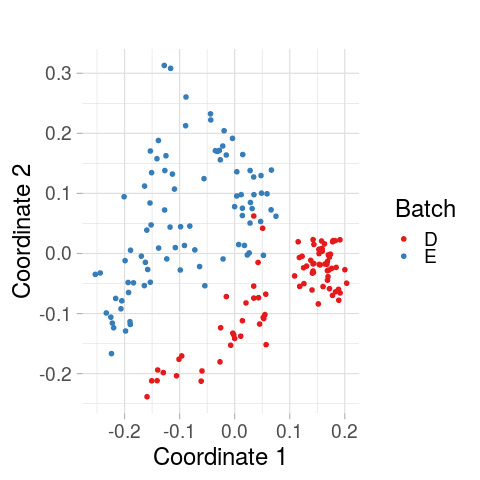

In [41]:
%%R
MDSClust <- plotMDS(cdFiltTop, k=2, groups=cellTypes, ret.val=TRUE, text.label=FALSE, title="")

In [42]:
%%R
pdf('MDS_All_updated_Without_Filtering.pdf')
MDSClust <- plotMDS(cdFiltTop, k=2, groups=cellTypes, ret.val=TRUE, text.label=FALSE, title="")
dev.off()


png 
  2 


From the above figure it was clear that MDS is seperating the cells based on batch. So there is a large batch effect here. This could be due to information coming predominantly from one batch. So I will now see how much zeros and ones the cells in each batch have.

In [39]:
%%R
cdDCell <- cdFiltTop[,4:87]
cdECell <- cdFiltTop[,88:176]
onesDCell <- rowSums(cdDCell)
zerosDCell <- dim(cdDCell)[2] - onesDCell
onesECell <- rowSums(cdECell)
zerosECell <- dim(cdECell)[2] - onesECell

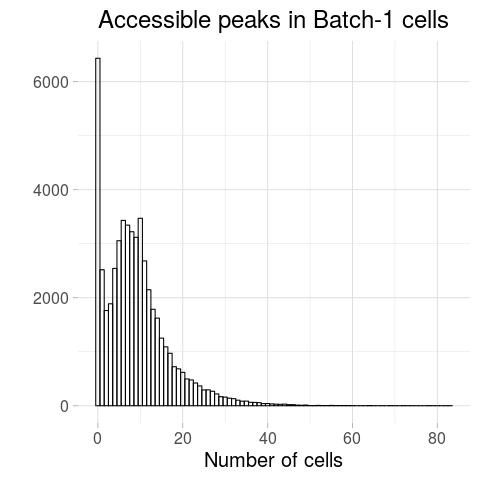

In [40]:
%%R
#hist(zerosDCell, xlab="Peakwise zeros in D cell", breaks=100, main="Histogram of zeros in D cell")
#pdf('hist_of_Ones_D.pdf')
hist1 <- qplot(onesDCell, geom="histogram",  binwidth = 1,fill=I("white"), 
      col=I("black"), 
      alpha=I(.2),) + xlab("Number of cells") + ggtitle("Accessible peaks in Batch-1 cells")

hist1 <- hist1 + theme_light(base_size=20) +
        theme(strip.background = element_blank(),
              panel.border     = element_blank(),
              plot.title = element_text(hjust = 0.5))
print(hist1)
#dev.off()

In [266]:
%%R
pdf('hist_of_Ones_D.pdf')
hist1 <- qplot(onesDCell, geom="histogram",  binwidth = 1,fill=I("white"), 
      col=I("black"), 
      alpha=I(.2),) + xlab("Number of cells") + ggtitle("Accessible peaks in Batch-1 cells")

hist1 <- hist1 + theme_light(base_size=20) +
        theme(strip.background = element_blank(),
              panel.border     = element_blank(),
              plot.title = element_text(hjust = 0.5))
print(hist1)
dev.off()

png 
  2 


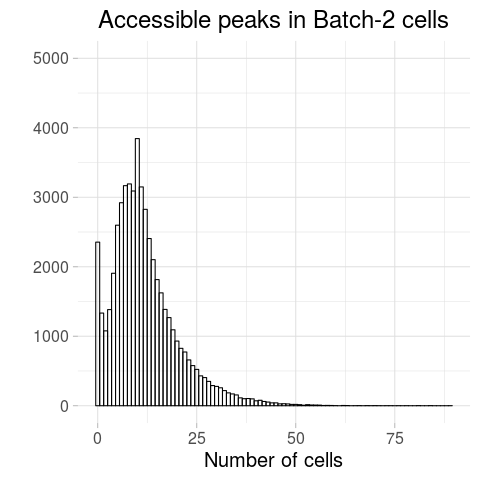

In [41]:
%%R
#hist(zerosDCell, xlab="Peakwise zeros in D cell", breaks=100, main="Histogram of zeros in D cell")
#pdf('hist_of_Ones_E.pdf')
hist1 <- qplot(onesECell, geom="histogram",  binwidth = 1,fill=I("white"), 
      col=I("black"), 
      alpha=I(.2),) + xlab("Number of cells") + ggtitle("Accessible peaks in Batch-2 cells") + ylim(0,5000)

hist1 <- hist1 + theme_light(base_size=20) +
        theme(strip.background = element_blank(),
              panel.border     = element_blank(),
              plot.title = element_text(hjust = 0.5))
print(hist1)
#dev.off()

In [267]:
%%R
pdf('hist_of_Ones_E.pdf')
hist1 <- qplot(onesECell, geom="histogram",  binwidth = 1,fill=I("white"), 
      col=I("black"), 
      alpha=I(.2),) + xlab("Number of cells") + ggtitle("Accessible peaks in Batch-2 cells") + ylim(0,5000)

hist1 <- hist1 + theme_light(base_size=20) +
        theme(strip.background = element_blank(),
              panel.border     = element_blank(),
              plot.title = element_text(hjust = 0.5))
print(hist1)
dev.off()

png 
  2 


So it is clear that Batch-1 is having more zeros than Batch-2 and OE19. So we would be applying an additional filtering

## Additional Filtering
We need an additional filtering on top of the `clean.count.peaks` so that number of ones in each batch is similar. In this filtering we would only keep the peaks that are observed in more than 2 peaks in each batch. 

In [43]:
%%R
cdFiltTopSel <- cdFiltTop[rowSums(cdFiltTop[,4:87])>2,]
cdFiltTopSel <- cdFiltTopSel[rowSums(cdFiltTopSel[,88:176])>2,]
print(dim(cdFiltTopSel))
#write.csv(cdFiltTopSel, 'cdFiltTopSel.csv', sep='\t')

[1] 37071   176


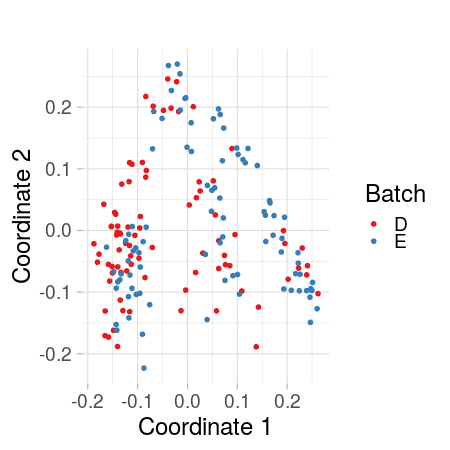

In [44]:
%%R -w 450 -h 450
MDSClust <- plotMDS(cdFiltTopSel, 3, groups=cellTypes, ret.val=TRUE, text.label=FALSE, title="")

In [45]:
%%R
pdf('MDS_updated_after_Batch_Correction.pdf')
MDSClust <- plotMDS(cdFiltTopSel, 3, groups=cellTypes, ret.val=TRUE, text.label=FALSE, title="")
dev.off()

png 
  2 


So this filtering clearly removes the batch effect and the cells are no longer seperated with batches.

In [58]:
%%R
write.table(cdFiltTopSel[,1:3], '/home/mqbsxsm2/Rna-seq_Data-Analysis/syed_scATAC_ReDoing/All_Filtered_BAM/MergedFilt_ReDo.txt', row.names=FALSE, sep='\t',quote=FALSE)

## K-medoid clustering

I would now apply k-medoid clustering to cluster the cells. As I already know that there are three cell-lines mixed I would choose k as three. While calculating k-medoid we passed the Jaccard distance as data value instead of actual data.

In [46]:
%%R
pamx <- pam(as.dist(getJaccardDist(cdFiltTopSel[,4:dim(cdFiltTopSel)[2]])), k=3, diss=TRUE)

So the k-medoid clusters the cells as-

In [47]:
%%R
table(pamx$clustering)


 1  2  3 
41 80 52 


In [48]:
%%R
clusterInfo <- data.frame(CellName = names(pamx$clustering), Cluster=pamx$clustering)

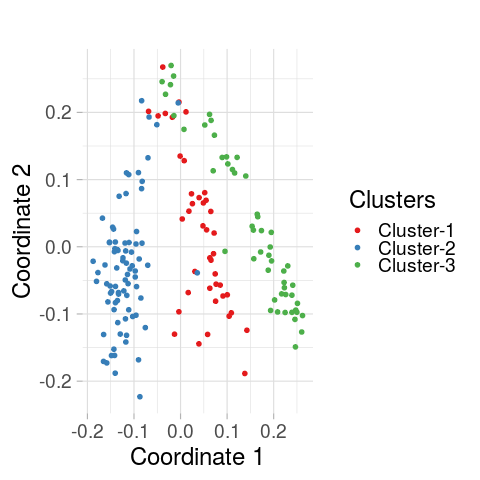

In [52]:
%%R
CellClust <- paste0('Cluster-',as.character(pamx$clustering))
MDSClust <- plotMDSClust(cdFiltTopSel, 4, Clusters=CellClust, ret.val=TRUE, text.label=FALSE, title="")

In [70]:
%%R
pdf('MDS_updated_Cluster.pdf')
MDSClust <- plotMDSClust(cdFiltTopSel, 4, Clusters=CellClust, ret.val=TRUE, text.label=FALSE, title="")
dev.off()

png 
  2 


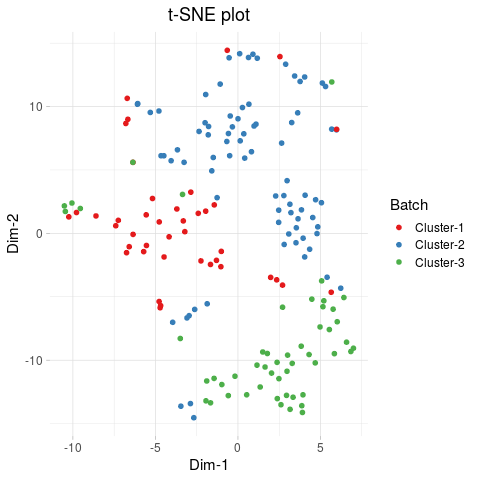

In [49]:
%%R
set.seed(100)
#pdf('tSNE-All-Batch.pdf')
tsNE_out_2PCs <- plot_tSNE(cdFiltTop, 14, groups=CellClust, perplexity=30, 
                              cellName=cellNames,ret.val=TRUE, text.label=F)

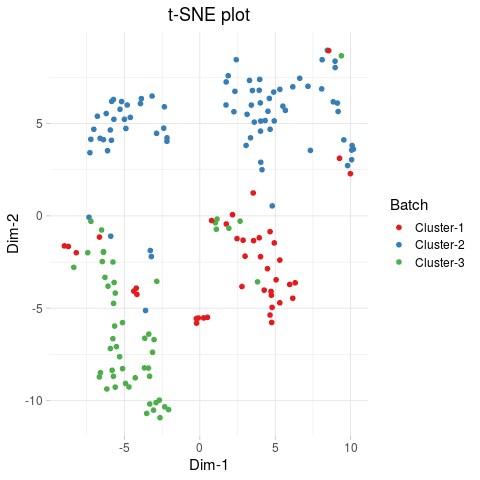

In [53]:
%%R
set.seed(100)
#pdf('tSNE-All-Batch.pdf')
tsNE_out_2PCs <- plot_tSNE(cdFiltTop, 6, groups=CellClust, perplexity=30, 
                              cellName=cellNames,ret.val=TRUE, text.label=F)

In [65]:
%%R
cellInfoWithClust <- data.frame(CellName = colnames(cdFiltTopSel[,4:dim(cdFiltTopSel)[2]]),
                               clusterInfo = CellClust)
cellInfoWithClust[cellInfoWithClust$clusterInfo=="Cluster-2",]

    CellName clusterInfo
2        D02   Cluster-2
3        D03   Cluster-2
5        D05   Cluster-2
6        D06   Cluster-2
7        D07   Cluster-2
8        D08   Cluster-2
9        D09   Cluster-2
11       D11   Cluster-2
12       D12   Cluster-2
13       D13   Cluster-2
14       D14   Cluster-2
16       D16   Cluster-2
17       D17   Cluster-2
18       D18   Cluster-2
19       D19   Cluster-2
21       D21   Cluster-2
22       D23   Cluster-2
24       D27   Cluster-2
30       D33   Cluster-2
31       D34   Cluster-2
33       D36   Cluster-2
35       D38   Cluster-2
36       D39   Cluster-2
37       D40   Cluster-2
44       D47   Cluster-2
46       D50   Cluster-2
48       D54   Cluster-2
51       D57   Cluster-2
53       D59   Cluster-2
56       D62   Cluster-2
58       D64   Cluster-2
60       D66   Cluster-2
62       D69   Cluster-2
63       D70   Cluster-2
64       D72   Cluster-2
66       D75   Cluster-2
67       D76   Cluster-2
69       D79   Cluster-2
70       D80   Cluster-2


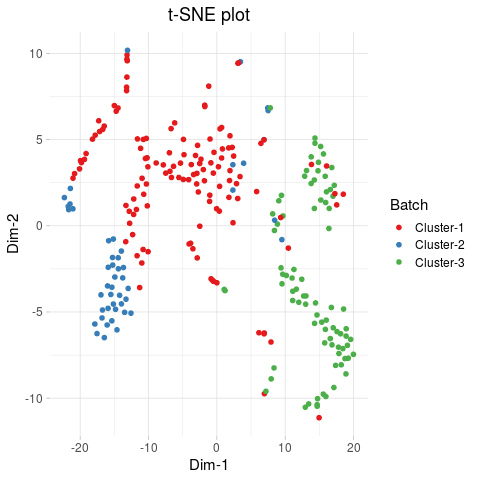

In [63]:
%%R
set.seed(100)
#pdf('tSNE-All-Batch.pdf')
tsNE_out_2PCs <- plot_tSNE(cdFiltTopSel, 14, groups=CellClust, perplexity=30, 
                              cellName=colnames(cdFiltTopSel[,4:dim(cdFiltTopSel)[2]]),ret.val=TRUE, text.label=F)

## Clustering purified cells with mixed population
We now cluster the two batches of OE19 single cells and the HET1A single cells from purified cells. This is to confirm that the clusters that we have identified from the mix population groups with their corresponding cell-type from the purified cell types.

We will use the same `mergedPeaksFilt.bed` that we have prepared from the mixture of the cell-population.

### HET1A cells peak accessiblity
We first identify the peak accessiblity for HET1A cells.

In [54]:
%%R
mergedPeakFile = '/home/mqbsxsm2/Rna-seq_Data-Analysis/syed_scATAC_ReDoing/All_Filtered_BAM/MergedFilt_ReDo.bed'
HET1ApeakFileFolder = '/home/mqbsxsm2/Rna-seq_Data-Analysis/syed_scATAC_ReDoing/HET1A_Batch1_Filtered_MACS2_files/'

In [69]:
%%R
peakAccessibility(mergedPeakFile,HET1ApeakFileFolder, '.narrowPeak', HET1ApeakFileFolder, 'HET1A_ReRun_peaks.csv')

In [55]:
%%R
HET1A_peakFile <- '/home/mqbsxsm2/Rna-seq_Data-Analysis/syed_scATAC_ReDoing/HET1A_Batch1_Filtered_MACS2_files/HET1A_ReRun_peaks.csv'

In [56]:
%%R
cdHET1A <- read.csv(HET1A_peakFile, sep=' ')
HET1Acellnames <- c(colnames(cdHET1A[,1:3]), paste0('HET1A-B1_C',gsub('X','',gsub('_.*','',colnames(cdHET1A[,4:dim(cdHET1A)[2]])))))
colnames(cdHET1A) <- HET1Acellnames

### OE19-B1 cells peak accessiblity
We first identify the peak accessiblity for OE19-B1 cells.

In [57]:
%%R
mergedPeakFile = '/home/mqbsxsm2/Rna-seq_Data-Analysis/syed_scATAC_ReDoing/All_Filtered_BAM/MergedFilt_ReDo.bed'
OE19_B1_peakFileFolder = '/home/mqbsxsm2/Rna-seq_Data-Analysis/syed_scATAC_ReDoing/OE19_Batch1_Filtered_MACS2_files/'

In [74]:
%%R
peakAccessibility(mergedPeakFile,OE19_B1_peakFileFolder, '.narrowPeak', OE19_B1_peakFileFolder, 'OE19_B1_ReRun_peaks.csv')

In [58]:
%%R
OE19_B1_peakFile <- '/home/mqbsxsm2/Rna-seq_Data-Analysis/syed_scATAC_ReDoing/OE19_Batch1_Filtered_MACS2_files/OE19_B1_ReRun_peaks.csv'

In [59]:
%%R
cdOE19_B1 <- read.csv(OE19_B1_peakFile, sep=' ')
OE19_B1cellnames <- c(colnames(cdOE19_B1[,1:3]), paste0('OE19-B1_C',gsub('X','',gsub('_.*','',colnames(cdOE19_B1[,4:dim(cdOE19_B1)[2]])))))
colnames(cdOE19_B1) <- OE19_B1cellnames

### OE19-B2 cells peak accessiblity
We first identify the peak accessiblity for OE19-B2 cells.

In [60]:
%%R
mergedPeakFile = '/home/mqbsxsm2/Rna-seq_Data-Analysis/syed_scATAC_ReDoing/All_Filtered_BAM/MergedFilt_ReDo.bed'
OE19_B2_peakFileFolder = '/home/mqbsxsm2/Rna-seq_Data-Analysis/syed_scATAC_ReDoing/OE19_Batch2_Filtered_MACS2_files/'

In [79]:
%%R
peakAccessibility(mergedPeakFile,OE19_B2_peakFileFolder, '.narrowPeak', OE19_B2_peakFileFolder, 'OE19_B2_ReRun_peaks.csv')

In [61]:
%%R
OE19_B2_peakFile <- '/home/mqbsxsm2/Rna-seq_Data-Analysis/syed_scATAC_ReDoing/OE19_Batch2_Filtered_MACS2_files/OE19_B2_ReRun_peaks.csv'

In [62]:
%%R
cdOE19_B2 <- read.csv(OE19_B2_peakFile, sep=' ')
OE19_B2cellnames <- c(colnames(cdOE19_B2[,1:3]), paste0('OE19-B2_C',gsub('X','',gsub('_.*','',colnames(cdOE19_B2[,4:dim(cdOE19_B2)[2]])))))
colnames(cdOE19_B2) <- OE19_B2cellnames

In [63]:
%%R
cdAll <- cbind(cdFiltTopSel,cdHET1A[,4:dim(cdHET1A)[2]],cdOE19_B1[,4:dim(cdOE19_B1)[2]],cdOE19_B2[,4:dim(cdOE19_B2)[2]])

In [64]:
%%R
cdAllSel <- cdAll[rowSums(cdAll[,4:87])>2,]
cdAllSel <- cdAllSel[rowSums(cdAllSel[,88:176])>2,]
cdAllSel <- cdAllSel[rowSums(cdAllSel[,177:252])>2,]
cdAllSel <- cdAllSel[rowSums(cdAllSel[,253:322])>2,]
cdAllSel <- cdAllSel[rowSums(cdAllSel[,323:408])>2,]
print(dim(cdAllSel))

[1] 17013   408


In [65]:
%%R
cellInfoWithClust <- data.frame(CellName = colnames(cdFiltTopSel[,4:dim(cdFiltTopSel)[2]]),
                               clusterInfo = CellClust)

In [66]:
%%R
cellTypes <- c(CellClust, 
               gsub('_.*','',colnames(cdHET1A[,4:dim(cdHET1A)[2]])),
               gsub('_.*','',colnames(cdOE19_B1[,4:dim(cdOE19_B1)[2]])),
               gsub('_.*','',colnames(cdOE19_B2[,4:dim(cdOE19_B2)[2]])))

In [67]:
%%R
cellTypes <- gsub('HET1A-B1','HET1A', cellTypes)

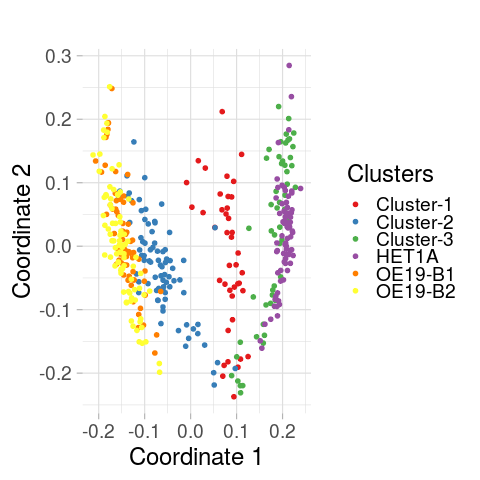

In [68]:
%%R
MDSClust <- plotMDSClust(cdAll, 4, Clusters=cellTypes, ret.val=TRUE, text.label=FALSE, title="")

In [69]:
%%R
pdf('MDS_withAll.pdf')
MDSClust <- plotMDSClust(cdAll, 4, Clusters=cellTypes, ret.val=TRUE, text.label=FALSE, title="")
dev.off()

png 
  2 


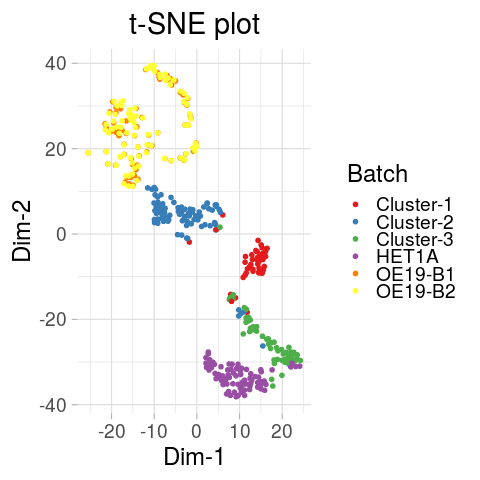

In [325]:
%%R
set.seed(100)
#pdf('tSNE-All-Batch.pdf')
tsNE_out_2PCs <- plot_tSNE(cdAll, 14, groups=cellTypes, perplexity=28, 
                              cellName=colnames(cdAll[,4:dim(cdAll)[2]]),ret.val=TRUE, text.label=F)

In [298]:
%%R
set.seed(100)
pdf('tSNE-Updated_All.pdf')
tsNE_out_2PCs <- plot_tSNE(cdAll, 14, groups=cellTypes, perplexity=28, 
                              cellName=colnames(cdAll[,4:dim(cdAll)[2]]),ret.val=TRUE, text.label=F)
dev.off()

png 
  2 


We could clearly see from the MDS and the t-SNE plot that Cluster-2 groups with OE19 cells, Cluster-3 groups with HET1A and Cluster-1 remains independent which we believe would be the OE33 cells. There are some mixture of cells in each of the groups, but we would still take the clusters that k-medoid gave.

## Generate Merged data for the clusters
Now we will have the merged data for each of the clusters

For Cluster-1

In [101]:
BAMFolderToMerge = '/home/mqbsxsm2/Rna-seq_Data-Analysis/syed_scATAC_ReDoing/Group1_BAM_files/'
getAggregatedPeak(BAMFolderToMerge, BAMFilePattern)

For Cluster-2

In [102]:
BAMFolderToMerge = '/home/mqbsxsm2/Rna-seq_Data-Analysis/syed_scATAC_ReDoing/Group2_BAM_files/'
getAggregatedPeak(BAMFolderToMerge, BAMFilePattern)

For Cluster-3

In [103]:
BAMFolderToMerge = '/home/mqbsxsm2/Rna-seq_Data-Analysis/syed_scATAC_ReDoing/Group3_BAM_files/'
getAggregatedPeak(BAMFolderToMerge, BAMFilePattern)

For HET1A-B1... for HET1A-B1, we would need to modify the macs2 calls to run the single-end data.

In [108]:
BAMFilePattern = '_nodup_noexclu_sorted.bam'
BAMFolderToMerge = '/home/mqbsxsm2/Rna-seq_Data-Analysis/syed_scATAC_ReDoing/HET1A_Filtered_BAM/'
getAggregatedPeakSE(BAMFolderToMerge, BAMFilePattern)

For OE19-B1. Similarly for OE19-B1, we would need to modify the macs2 calls to run the single-end data.

In [109]:
BAMFilePattern = '_nodup_noexclu_sorted.bam'
BAMFolderToMerge = '/home/mqbsxsm2/Rna-seq_Data-Analysis/syed_scATAC_ReDoing/OE19_Batch1_Filtered_BAM/'
getAggregatedPeakSE(BAMFolderToMerge, BAMFilePattern)

For OE19-B2

In [111]:
BAMFilePattern = '_nodup_sorted.bam'
BAMFolderToMerge = '/home/mqbsxsm2/Rna-seq_Data-Analysis/syed_scATAC_ReDoing/OE19_Batch2_Filtered_BAM/'
getAggregatedPeak(BAMFolderToMerge, BAMFilePattern)

In [104]:
BAMFilePattern

'_nodup_sorted_cleaned.bam'

## Correlation wth Bulk dataset

Now in order to find out which of the clusters correspond to which cell type we would calculate the correlation of each cluster with Bulk dataset of HET1A, OE19 and OE33. We have already writen the filtered peaks in the `mergedPeaksFilt.bed` file. We have also merged the BAM files for all cells in each individual cluster and call peaks on those merged files. All the peaks are then saved in the folder `Group_Peak_Files_with_Sig_Corr_Cluster`. 

Calculating peak accessibility for each clusters.

In [128]:
%%R
mergedPeakFile = '/home/mqbsxsm2/Rna-seq_Data-Analysis/syed_scATAC_ReDoing/All_Filtered_BAM/MergedFilt_ReDo.bed'
GroupPeakFolder='/home/mqbsxsm2/Rna-seq_Data-Analysis/syed_scATAC_ReDoing/AllCluster_Bulk_Files/'
peakAccessibility(mergedPeakFile,GroupPeakFolder, '.narrowPeak', GroupPeakFolder, 'All_sc_and_Bulk_Peaks.csv')

Reading peak files for clusters.

In [275]:
%%R
cdAll <- read.csv('/home/mqbsxsm2/Rna-seq_Data-Analysis/syed_scATAC_ReDoing/AllCluster_Bulk_Files/All_sc_and_Bulk_Peaks.csv',
                           header=TRUE, sep=' ')

We now calculate the correlation agains each other.

In [276]:
%%R
colnames(cdAll)

 [1] "seqnames"                "start"                  
 [3] "end"                     "Cluster1_Filtered_peaks"
 [5] "Cluster2_Filtered_peaks" "Cluster3_Filtered_peaks"
 [7] "HET1A.B1_Filtered_peaks" "HET1A.Bulk_peaks"       
 [9] "OE19.B1_Filtered_peaks"  "OE19.B2_Filtered_peaks" 
[11] "OE19.Bulk_peaks"         "OE33.Bulk_peaks"        


In [278]:
%%R
colnames(cdAll) <- c(colnames(cdAll[,1:3]), gsub('_.*','',colnames(cdAll[,4:dim(cdAll)[2]])))

In [280]:
%%R
colnames(cdAll) <- c(colnames(cdAll[,1:6]), 'HET1A', colnames(cdAll[,8:12]))
colnames(cdAll)

 [1] "seqnames"   "start"      "end"        "Cluster1"   "Cluster2"  
 [6] "Cluster3"   "HET1A"      "HET1A.Bulk" "OE19.B1"    "OE19.B2"   
[11] "OE19.Bulk"  "OE33.Bulk" 


In [281]:
%%R
M <- cor(cdAll[,4:dim(cdAll)[2]], method="pearson")

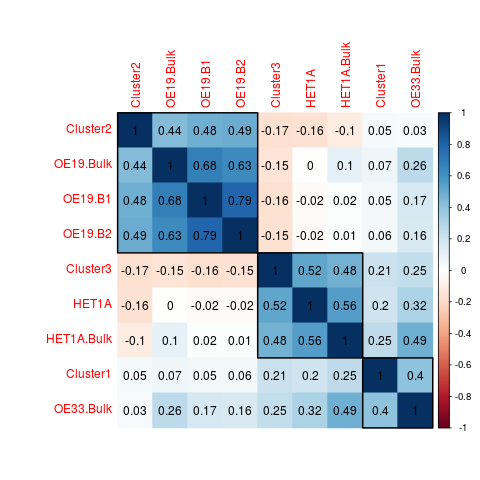

In [282]:
%%R
corrplot(M, method="color", p.mat = M, insig = "p-value", sig.level=-1, order="hclust", addrect=3)

In [283]:
%%R
pdf('corHeat_updated.pdf')
corrplot(M, method="color", p.mat = M, insig = "p-value", sig.level=-1, order="hclust", addrect=3)
dev.off()

png 
  2 


The correlation coefficients are printed in each cell. we set the `sig.level` to -1 so that all the values are printed in the plot. From the plot it we could assign Cluster1 with OE33, Cluster2 with  OE19 and Cluster3 with HET1A. 

## Differential Accessibility (Cluster1 vs Cluster2)
We now calculate Differential Accessibility to find out the peaks that are differentially accessible in Cluster1 and Cluster2. As we know that cells in these two groups are associated with OE33 and OE19 respectively, the expressed genes are also very similar. So it is interesting to find out the genes that are differentially expressed in these two cells.

We first extract the cells in each cluster and their count data.

In [134]:
%%R
c1CellName <- names(pamx$clustering[pamx$clustering == 1])
c2CellName <-  names(pamx$clustering[pamx$clustering == 2])
c3CellName <-  names(pamx$clustering[pamx$clustering == 3])
c1CountData <- cdFiltTopSel[,as.character(c1CellName)]
colnames(c1CountData) <- paste0('C1_', colnames(c1CountData))
c2CountData <- cdFiltTopSel[,as.character(c2CellName)]
colnames(c2CountData) <- paste0('C2_', colnames(c2CountData))
c3CountData <- cdFiltTopSel[,as.character(c3CellName)]
colnames(c3CountData) <- paste0('C3_', colnames(c3CountData))

We prepare the data for DE analysis

In [135]:
%%R
CellCluster.Annot.counts <- cbind(cdFiltTopSel[,1:3], c1CountData ,c2CountData)
rownames(CellCluster.Annot.counts) <- paste0(cdFiltTopSel[,1],'_',cdFiltTopSel[,2],'_',cdFiltTopSel[,3])
sg <- factor(gsub("(C1|C2).*", "\\1", colnames(CellCluster.Annot.counts[,4:dim(CellCluster.Annot.counts)[2]])), 
             levels = c("C1", "C2"))
# the group factor should be named accordingly
names(sg) <- colnames(CellCluster.Annot.counts[,4:dim(CellCluster.Annot.counts)[2]]) 
table(sg)

sg
C1 C2 
41 80 


In [136]:
%%R
start.time <- Sys.time()
diffRes <- getDiffAccessInformationGain(CellCluster.Annot.counts, groups=sg)
end.time <- Sys.time()
time.taken <- end.time - start.time
time.taken

Time difference of 2.1992 mins


We consider all the peaks that have an information gain of above 0.01 to be significant. So we extract those peaks.

In [137]:
%%R
significantDEpeaks <- diffRes
significantDEpeaks <- significantDEpeaks[order(significantDEpeaks$information.gain, decreasing=TRUE),]
significantDEpeaks <- significantDEpeaks[significantDEpeaks$information.gain>0.01,]
rownames(significantDEpeaks) <- paste0(significantDEpeaks[,1],'_',significantDEpeaks[,2],'_',significantDEpeaks[,3])
print(dim(significantDEpeaks))

[1] 12583     7


There are 5365 peaks that are significantly differentially accessible in OE19 and OE33.

In [138]:
%%R
head(significantDEpeaks)

                            Chr     Start       end information.gain
chr17_39535097_39537584   chr17  39535097  39537584        0.2671008
chr9_37963667_37965216     chr9  37963667  37965216        0.2318043
chr5_912358_913095         chr5    912358    913095        0.2202554
chr17_35846992_35851866   chr17  35846992  35851866        0.2178187
chr10_106908425_106909662 chr10 106908425 106909662        0.2086013
chr13_30646183_30647194   chr13  30646183  30647194        0.1977572
                          rawMeanGroup1 rawMeanGroup2 log2FoldChange
chr17_39535097_39537584      0.70731707        0.0375       4.237395
chr9_37963667_37965216       0.07317073        0.7500      -3.357552
chr5_912358_913095           0.65853659        0.0500       3.719264
chr17_35846992_35851866      0.87804878        0.2125       2.046838
chr10_106908425_106909662    0.60975610        0.0375       4.023270
chr13_30646183_30647194      0.02439024        0.6125      -4.650334


We identify the peaks that are highly open in OE33 cells.

In [143]:
%%R
sigOE33 <- significantDEpeaks[significantDEpeaks$log2FoldChange>0,]

## Annotating peaks

We annotate the genes associated with the peaks now

Converting the peaks to GRanges object

In [144]:
%%R
gr1 <- makeGRangesFromDataFrame(as.data.frame(sigOE33[,1:3]),
                         keep.extra.columns=FALSE,
                         ignore.strand=TRUE,
                         seqinfo=NULL,
                         seqnames.field="Chr",
                         #start.field="start",
                         #end.field=c("end", "stop"),                         
                         starts.in.df.are.0based=FALSE)
metaData <- data.frame(peakNames = rownames(sigOE33), stringsAsFactors=FALSE)
mcols(gr1) <- metaData

### Prepare annotation data

Annotation data should be an object of GRanges. We use the method toGRanges, which can return an object of GRanges, to represent the annotation data. An annotation data be constructed from not only BED, GFF or user defined readable text files, but also EnsDb or TxDb object, by calling the toGRanges method. 

In [145]:
%%R
annoData <- toGRanges(EnsDb.Hsapiens.v75, feature="gene")
annoData[1:2,'gene_name']

GRanges object with 2 ranges and 1 metadata column:
                  seqnames         ranges strand |   gene_name
                     <Rle>      <IRanges>  <Rle> | <character>
  ENSG00000223972     chr1 [11869, 14412]      + |     DDX11L1
  ENSG00000227232     chr1 [14363, 29806]      - |      WASH7P
  -------
  seqinfo: 273 sequences from GRCh37 genome


### Annotate peaks

Now we will use `annotatePeakInBatch()` or `annoPeaks()` to annotate the peaks to the overlaping regions of Hg19 genes.

In [146]:
%%R
gr1.anno <- annotatePeakInBatch(gr1, 
                                     AnnotationData=annoData, 
                                     #output="nearestBiDirectionalPromoters",
                                     output = "overlapping",
                                     #bindingRegion=c(-2000, 500))
                                     maxgap=100)
gr1.anno <- addGeneIDs(gr1.anno,
                            "org.Hs.eg.db",
                            IDs2Add = "symbol")
print(head(gr1.anno$symbol))

[1] "KRT34"  "TRIP13" NA       "SORCS3" "DIP2C"  NA      


In [147]:
%%R
write.csv(gr1.anno$symbol, 'OE33_Significant.csv')

One gene that have differential accessibillity in OE33 cells are _CAV1_ for which we visualize the peaks associated with this gene location in UCSCS browser which is reported in the paper. 

## Differential Accessibility (Cluster2 vs Cluster3)
We now calculate Differential Accessibility to find out the peaks that are differentially accessible in Cluster2 and Cluster3. As we know that cells in these two groups are associated with OE19 and HET1A respectively, the expressed genes are also very similar. So it is interesting to find out the genes that are differentially expressed in these two cells.

We first extract the cells in each cluster and their count data.

We prepare the data for DE analysis

In [148]:
%%R
CellCluster.Annot.counts <- cbind(cdFiltTopSel[,1:3], c2CountData ,c3CountData)
rownames(CellCluster.Annot.counts) <- paste0(cdFiltTopSel[,1],'_',cdFiltTopSel[,2],'_',cdFiltTopSel[,3])
sg <- factor(gsub("(C2|C3).*", "\\1", colnames(CellCluster.Annot.counts[,4:dim(CellCluster.Annot.counts)[2]])), 
             levels = c("C2", "C3"))
# the group factor should be named accordingly
names(sg) <- colnames(CellCluster.Annot.counts[,4:dim(CellCluster.Annot.counts)[2]]) 
table(sg)

sg
C2 C3 
80 52 


In [149]:
%%R
start.time <- Sys.time()
diffRes <- getDiffAccessInformationGain(CellCluster.Annot.counts, groups=sg)
end.time <- Sys.time()
time.taken <- end.time - start.time
time.taken

Time difference of 2.174719 mins


We consider all the peaks that have an information gain of above 0.01 to be significant. So we extract those peaks.

In [192]:
%%R
significantDEpeaks <- diffRes
significantDEpeaks <- significantDEpeaks[order(significantDEpeaks$information.gain, decreasing=TRUE),]
significantDEpeaks <- significantDEpeaks[significantDEpeaks$information.gain>0.01,]
rownames(significantDEpeaks) <- paste0(significantDEpeaks[,1],'_',significantDEpeaks[,2],'_',significantDEpeaks[,3])
print(dim(significantDEpeaks))

[1] 15391     7


There are 15391 peaks that are significantly differentially accessible in OE19 and HET1A.

In [193]:
%%R
head(significantDEpeaks)

                           Chr     Start       end information.gain
chr17_37858661_37867115  chr17  37858661  37867115        0.3570128
chr17_37852761_37858463  chr17  37852761  37858463        0.3418310
chr17_39944768_39950869  chr17  39944768  39950869        0.3070466
chr7_157101284_157103548  chr7 157101284 157103548        0.2862330
chr9_71354539_71356329    chr9  71354539  71356329        0.2683219
chr6_42084948_42087120    chr6  42084948  42087120        0.2631854
                         rawMeanGroup1 rawMeanGroup2 log2FoldChange
chr17_37858661_37867115         0.9750    0.21153846       2.204482
chr17_37852761_37858463         0.9750    0.23076923       2.078951
chr17_39944768_39950869         0.9625    0.25000000       1.944858
chr7_157101284_157103548        0.0250    0.69230769      -4.791413
chr9_71354539_71356329          0.7250    0.03846154       4.236493
chr6_42084948_42087120          0.7750    0.07692308       3.332708


We identify the peaks that are highly open in OE19 cells.

In [206]:
%%R
sigOE19 <- significantDEpeaks[significantDEpeaks$log2FoldChange>0,]
sigHET1A <- significantDEpeaks[significantDEpeaks$log2FoldChange<0,]

## Annotating peaks

We annotate the genes associated with the peaks now

Converting the peaks to GRanges object

In [207]:
%%R
gr1 <- makeGRangesFromDataFrame(as.data.frame(sigOE19[,1:3]),
                         keep.extra.columns=FALSE,
                         ignore.strand=TRUE,
                         seqinfo=NULL,
                         seqnames.field="Chr",
                         #start.field="start",
                         #end.field=c("end", "stop"),                         
                         starts.in.df.are.0based=FALSE)
metaData <- data.frame(peakNames = rownames(sigOE19), stringsAsFactors=FALSE)
mcols(gr1) <- metaData

### Prepare annotation data

Annotation data should be an object of GRanges. We use the method toGRanges, which can return an object of GRanges, to represent the annotation data. An annotation data be constructed from not only BED, GFF or user defined readable text files, but also EnsDb or TxDb object, by calling the toGRanges method. 

In [208]:
%%R
annoData <- toGRanges(EnsDb.Hsapiens.v86, feature="gene")
annoData[1:2,'gene_name']

GRanges object with 2 ranges and 1 metadata column:
                  seqnames         ranges strand |   gene_name
                     <Rle>      <IRanges>  <Rle> | <character>
  ENSG00000223972     chr1 [11869, 14409]      + |     DDX11L1
  ENSG00000227232     chr1 [14404, 29570]      - |      WASH7P
  -------
  seqinfo: 357 sequences from GRCh38 genome


### Annotate peaks

Now we will use `annotatePeakInBatch()` or `annoPeaks()` to annotate the peaks to the overlaping regions of Hg19 genes.

In [209]:
%%R
gr1.anno <- annotatePeakInBatch(gr1, 
                                     AnnotationData=annoData, 
                                     #output="nearestBiDirectionalPromoters",
                                     output = "overlapping",
                                     #bindingRegion=c(-2000, 500))
                                     maxgap=100)
gr1.anno <- addGeneIDs(gr1.anno,
                            "org.Hs.eg.db",
                            IDs2Add = "symbol")
print(head(gr1.anno$symbol))

[1] "YWHAEP7" "YWHAEP7" "LRRC3C"  "TRPM3"   "TAF8"    NA       


In [210]:
%%R
write.csv(gr1.anno$symbol, 'OE19_Significant.csv')

Two genes reported in the literature that are differentially expressed in OE19 are _GATA6_ and _PPFIA3_. Peaks associated with these two genes also have differential accessibility in our OE19 significant peaks. We then visualize the peaks of these two gene location in UCSCS browser which is reported in the paper. 

## Disease ontology analysis

We now do a disease ontology analysis with the OE19 significant peaks and HET1A significant peaks. We will first identify the disease ontoogy assocaited with OE19 cells and then will try to find the significance of same disease ontology on HET1A cells. 

In [211]:
%%R
singOE19Sel <- sigOE19[sigOE19$log2FoldChange>2,]

In [212]:
%%R
bedg1 = singOE19Sel
jobg1 = submitGreatJob(bedg1, version = "3.0", species='hg19')

In [213]:
%%R -w 550 -h 350
tbDisG1 = getEnrichmentTables(jobg1, ontolog="Disease Ontology")
dftbDisG1 = data.frame(Name = tbDisG1[[1]][,2], Binom_p=-log10(tbDisG1[[1]][,8]))

In [214]:
%%R
dftbDisG1[1:30,]

                                   Name  Binom_p
1                                cancer 35.66909
2                             carcinoma 31.02175
3                  epithelial carcinoma 30.08280
4            reproductive system cancer 25.23526
5          malignant neoplasm of thorax 24.58818
6          malignant neoplasm of breast 24.49216
7                       thoracic cancer 24.07995
8           cancer by anatomical entity 23.91215
9                        mammary cancer 23.10336
10                       adenocarcinoma 22.89754
11                              disease 22.38073
12                        neck neoplasm 21.70345
13                          neck cancer 21.61245
14         disease of anatomical entity 20.83940
15   glandular cell epithelial neoplasm 20.60640
16               squamous cell neoplasm 20.44316
17    glandular and epithelial neoplasm 19.48848
18                      T-cell leukemia 19.46805
19                       POEMS syndrome 19.37241
20                 n

In [217]:
%%R
sigHET1ASel <- sigHET1A[sigHET1A$log2FoldChange < (-2),]

In [218]:
%%R
bedg2 = sigHET1A[,1:3]
jobg2 = submitGreatJob(bedg2, version = "3.0", species='hg19')

/home/mqbsxsm2/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Don't make too frequent requests. The time break is 300s.
Please wait for 143s for the next request.
The time break can be set by `request_interval` argument.


  warnings.warn(x, RRuntimeWarning)


  |======================================================================| 100%


In [219]:
%%R -w 550 -h 350
tbDisG2 = getEnrichmentTables(jobg2, ontolog="Disease Ontology")
dftbDisG2 = data.frame(Name = tbDisG2[[1]][,2], Binom_p=-log10(tbDisG2[[1]][,8]))

In [220]:
%%R
dftbDisG2[1:30,]

                                         Name  Binom_p
1              dsDNA virus infectious disease 22.89563
2                DNA virus infectious disease 20.41672
3                  reproductive system cancer 19.68900
4                              mammary cancer 19.52828
5  progressive multifocal leukoencephalopathy 18.72189
6            Herpesviridae infectious disease 18.06720
7                       female genital cancer 17.47434
8                malignant neoplasm of breast 17.24607
9          Cytomegalovirus infectious disease 17.24238
10               malignant neoplasm of thorax 17.12734
11                            thoracic cancer 16.54006
12                                     cancer 16.09954
13                           ovarian neoplasm 16.07262
14                     squamous cell neoplasm 15.36043
15                   viral infectious disease 15.35467
16                 female reproductive cancer 15.25368
17                 neoplasm of body of uterus 15.08738
18        

In [221]:
%%R
topG1 <- dftbDisG1[1:15,]
#Adding the esophageal carcinoma as well as OE19 cells are esophageal carcinoma
topG1 <- rbind(topG1,dftbDisG1[grep('esophageal carcinoma',dftbDisG1$Name),])

In [222]:
%%R
clstTopInter <- dftbDisG2[as.character(dftbDisG2$Name) %in% as.character(topG1$Name),]

In [223]:
%%R
clstTopInter

                                  Name   Binom_p
3           reproductive system cancer 19.689002
4                       mammary cancer 19.528279
8         malignant neoplasm of breast 17.246065
10        malignant neoplasm of thorax 17.127343
11                     thoracic cancer 16.540064
12                              cancer 16.099542
33                      adenocarcinoma 12.214813
41         cancer by anatomical entity 11.160126
45                epithelial carcinoma 10.755831
47  glandular cell epithelial neoplasm 10.730023
136       disease of anatomical entity  6.756053
141                          carcinoma  6.627016
216                        neck cancer  4.936358
223                      neck neoplasm  4.889893
294                            disease  4.056264
313               esophageal carcinoma  3.866564


In [224]:
%%R
dbBoth <- data.frame(Name=topG1$Name, Cluster2=topG1$Binom_p, Cluster3=clstTopInter$Binom_p)
dbBoth[13,3] = 0.9812
dbBoth

                                 Name  Cluster2  Cluster3
1                              cancer 35.669090 19.689002
2                           carcinoma 31.021753 19.528279
3                epithelial carcinoma 30.082802 17.246065
4          reproductive system cancer 25.235257 17.127343
5        malignant neoplasm of thorax 24.588176 16.540064
6        malignant neoplasm of breast 24.492162 16.099542
7                     thoracic cancer 24.079950 12.214813
8         cancer by anatomical entity 23.912145 11.160126
9                      mammary cancer 23.103356 10.755831
10                     adenocarcinoma 22.897540 10.730023
11                            disease 22.380727  6.756053
12                      neck neoplasm 21.703447  6.627016
13                        neck cancer 21.612454  0.981200
14       disease of anatomical entity 20.839405  4.889893
15 glandular cell epithelial neoplasm 20.606401  4.056264
16               esophageal carcinoma  6.914241  3.866564


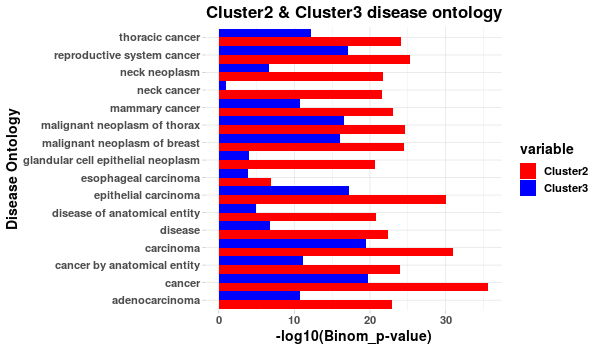

In [225]:
%%R -w 600 -h 350
library(reshape)
df.long<-melt(dbBoth)
p <- ggplot(df.long,aes(Name,value,fill=variable)) + ggtitle('Cluster2 & Cluster3 disease ontology') +
    geom_bar(stat="identity",position="dodge",width = 1) + coord_flip()+
        theme_light(base_size=12) +
        theme(text=element_text(size=14,  face="bold"),
            strip.background = element_blank(),
              panel.border     = element_blank(),
              plot.title = element_text(hjust = 0.5))+ xlab("Disease Ontology") + 
             ylab("-log10(Binom_p-value)") +  
             scale_fill_manual("variable", values = c("Cluster2" = "red", "Cluster3" = "blue"))
print(p)

In [305]:
%%R -w 600 -h 350
pdf('Disease_ontology_updated.pdf', width=10, height=5)
#library(reshape)
df.long<-melt(dbBoth)
p <- ggplot(df.long,aes(Name,value,fill=variable)) + ggtitle('Cluster2 & Cluster3 disease ontology') +
    geom_bar(stat="identity",position="dodge",width = 1) + coord_flip()+
        theme_light(base_size=12) +
        theme(text=element_text(size=14,  face="bold"),
            strip.background = element_blank(),
              panel.border     = element_blank(),
              plot.title = element_text(hjust = 0.5))+ xlab("Disease Ontology") + 
             ylab("-log10(Binom_p-value)") +  
             scale_fill_manual("variable", values = c("Cluster2" = "red", "Cluster3" = "blue"))
print(p)
dev.off()

png 
  2 


## Recall vs precision

Scasat also has a functionality to plot the recall vs precision. Here we are doing it for class2 cells agains Bulk OE19 to see the sensitivity or TRUE positive rate for peaks that are differentially accessible in OE19 vs HET1A with statistical significance.

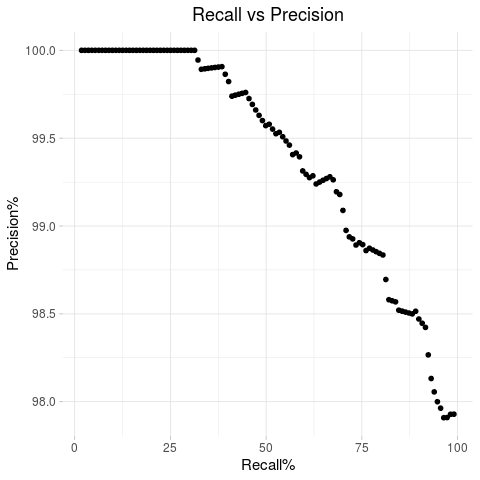

In [229]:
%%R
OE19_peaks <- read.table('/home/mqbsxsm2/Rna-seq_Data-Analysis/syed_scATAC_ReDoing/AllCluster_Bulk_Files/OE19.Bulk_peaks.narrowPeak',
                        sep='\t', header=FALSE)


colnames(OE19_peaks) <- c('chr','start','end')
#pdf('Recall_vs_precision_OE19_Clust2.pdf')
getPeakVsPrecision(OE19_peaks[,1:3], sigOE19[,1:3], stepSize=50)
#dev.off()


In [270]:
%%R
pdf('Recall_vs_precision_OE19_Clust2.pdf')
getPeakVsPrecision(OE19_peaks[,1:3], sigOE19[,1:3], stepSize=50)
dev.off()

png 
  2 


In [230]:
%%R
save.image('ScAsAT_Deconv_Redo.RData')